<a href="https://colab.research.google.com/github/samwong3333/try/blob/main/6_OptimalPortfolio_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid",
              palette="colorblind", color_codes=True,
              rc={"figure.figsize": [12, 8]})

In [ ]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

In [ ]:
# change directory from google colab into google drive, connect to google drive first
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change the present working directory
import os
os.chdir('/content/drive/MyDrive/')

# Asset Allocation in Python

Asset allocation is the most important decision that any investor needs to face, and there is no one-size-fits-all solution that can work for each and every investor. By asset allocation, we mean spreading the investor's total investment amount over certain assets (be it stocks, options, bonds, or any other financial instruments). When considering the allocation, the investor wants to balance the risk and the potential reward. At the same time, the allocation is dependent on factors such as the individual goals (expected return), risk tolerance (how much risk is the investor willing to accept), or the investment horizon (short or long-term investment).

The key framework in asset allocation is the **modern portfolio theory** (**MPT**, also known as **mean-variance analysis**). It was introduced by the Nobel recipient Harry Markowitz and describes how risk-averse investors can construct portfolios to maximize their expected returns (profits) for a given level of risk. The main insight from MPT is that investors should not evaluate an asset's performance alone (by metrics such as expected return or volatility), but instead investigate how it would impact the performance of their portfolio of assets.

MPT is closely related to the concept of diversification, which simply means that owning different kinds of assets reduces risk, as the loss or gain of a particular security has less impact on the portfolio’s performance. Another key concept to be aware of is that while the portfolio return is the weighted average of the individual asset returns, this is not true for the risk (volatility). It is also dependent on the correlations between the assets. What is interesting is that thanks to optimized asset allocation, it is possible to have a portfolio with lower volatility than the lowest individual volatility of the assets in the portfolio. In principle, the lower the correlation between the assets we hold, the better it is for diversification. With a perfect negative correlation, we could diversify all the risk.

The main assumptions of modern portfolio theory are:

* Investors are rational and aim to maximize their returns, while avoiding risks whenever possible.
* Investors share the goal to maximize their expected returns.
* All investors have the same level of information about potential investments.
* Commissions, taxes, and transaction costs are not taken into account.
* Investors can borrow and lend money (without limits) at a risk-free rate.

In this chapter, we start with the most basic asset allocation strategy, and on its basis learn how to evaluate the performance of portfolios (also applicable to individual assets). Later on, we show three different approaches to obtaining the Efficient Frontier, while also relaxing some of the assumptions of MPT. One of the main benefits of learning how to approach optimization problems is that they can be easily refactored, for example, optimizing a different objective function. This requires only slight modifications to the code, while the majority of the framework stays the same.

We cover the following recipes in this chapter:

* Evaluating the performance of a basic 1/n portfolio
* Finding the Efficient Frontier using Monte Carlo simulations
* Finding the Efficient Frontier using optimization with `scipy`
* Finding the Efficient Frontier using convex optimization with `cvxpy`

## Evaluating the performance of a basic 1/n portfolio

We begin with inspecting the most basic asset allocation strategy: the **1/n portfolio**. The idea is to assign equal weights to all the considered assets, thus diversifying the portfolio. As simple as that might sound, DeMiguel, Garlappi, and Uppal (2007) show that it can be difficult to beat the performance of the 1/n portfolio by using more advanced asset allocation strategies.

The goal of the recipe is to show how to create a 1/n portfolio, calculate its returns, and then use a Python library called `pyfolio` to quickly obtain all relevant portfolio evaluation metrics in the form of a tear sheet. Historically, a tear sheet is a concise, usually one-page, document, summarizing important information about public companies.

### How to do it...

1. Import the libraries:

In [ ]:
pip install pyfolio;

Remarks:
* If you encounter error message `simplejson.errors.JSONDecodeError: Expecting value: line 1 column 1 (char 0)` when using `yf.donwload` to download information for multiple tickers, you may upgrade your yfinance to 0.1.62.

In [ ]:
!pip install yfinance
#==0.1.62

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import pyfolio as pf

In [ ]:
pf.__path__

['/usr/local/lib/python3.11/dist-packages/pyfolio']

2. Set up the parameters:

In [ ]:
# stock prices of four US tech companies (Apple, IBM, Microsoft, and Twitter) over the years 2017-2018
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
START_DATE = '2017-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

3. Download the stock prices from Yahoo Finance:

In [ ]:
yf.download(RISKY_ASSETS,
                 start=START_DATE,
                 end=END_DATE,
                 #adjusted=True,
                 progress=False)

Price           Close                              High              \
Ticker           AAPL         IBM       MSFT       AAPL         IBM   
Date                                                                  
2017-01-03  26.862419  110.585258  56.601124  26.904048  111.035038   
2017-01-04  26.832363  111.954422  56.347881  26.945688  112.357898   
2017-01-05  26.968813  111.584015  56.347881  27.026631  112.040403   
2017-01-06  27.269470  112.133018  56.836288  27.327289  112.390978   
2017-01-09  27.519243  110.889511  56.655392  27.621004  112.311596   
...               ...         ...        ...        ...         ...   
2018-12-21  35.952221   79.673538  92.401314  37.724431   82.790386   
2018-12-24  35.021988   77.253296  88.544571  36.147806   79.716612   
2018-12-26  37.488293   79.996704  94.593048  37.502603   79.996704   
2018-12-27  37.244995   81.713150  95.176254  37.392880   81.713150   
2018-12-28  37.264091   81.174507  94.433151  37.810306   82.445665   

Price                        Low                              Open  \
Ticker           MSFT       AAPL         IBM       MSFT       AAPL   
Date                                                                 
2017-01-03  56.836282  26.540949  109.804762  56.194116  26.781474   
2017-01-04  56.754889  26.769920  110.697701  56.185078  26.793047   
2017-01-05  56.673488  26.783793  110.631556  56.103677  26.809234   
2017-01-06  57.116672  26.936436  110.803539  56.112721  27.008130   
2017-01-09  57.053356  27.276407  110.869664  56.564947  27.278719   
...               ...        ...         ...        ...        ...   
2018-12-21  96.888272  35.689850   79.314454  91.676999  37.414354   
2018-12-24  92.156719  34.964742   77.203027  88.403477  35.336833   
2018-12-26  94.715339  34.995752   76.082694  88.384675  35.372616   
2018-12-27  95.185663  35.794793   78.617845  90.679888  37.171054   
2018-12-28  96.333294  36.863378   80.793879  93.614772  37.567014   

Price                                 Volume                       
Ticker             IBM       MSFT       AAPL       IBM       MSFT  
Date                                                               
2017-01-03  110.459588  56.791060  115127600   3069278   20694100  
2017-01-04  110.968888  56.510684   84472400   3536944   21340000  
2017-01-05  111.947808  56.248390   88774400   2805686   24876000  
2017-01-06  111.577416  56.347879  127007600   3080993   19922900  
2017-01-09  112.093321  56.763926  134247600   3336635   20382700  
...                ...        ...        ...       ...        ...  
2018-12-21   80.793879  95.599562  382978400  10864279  111242100  
2018-12-24   78.926631  91.883926  148676800   3997184   43935200  
2018-12-26   77.562119  89.494657  234330000   6951507   51634800  
2018-12-27   78.991292  93.407811  212468400   6323698   49498500  
2018-12-28   82.029125  96.032275  169165600   5352905   38196300  

[501 rows x 15 columns]

[*********************100%***********************]  3 of 3 completed


Downloaded 501 rows of data.


<Axes: title={'center': 'Stock prices of the considered assets'}, xlabel='Date'>

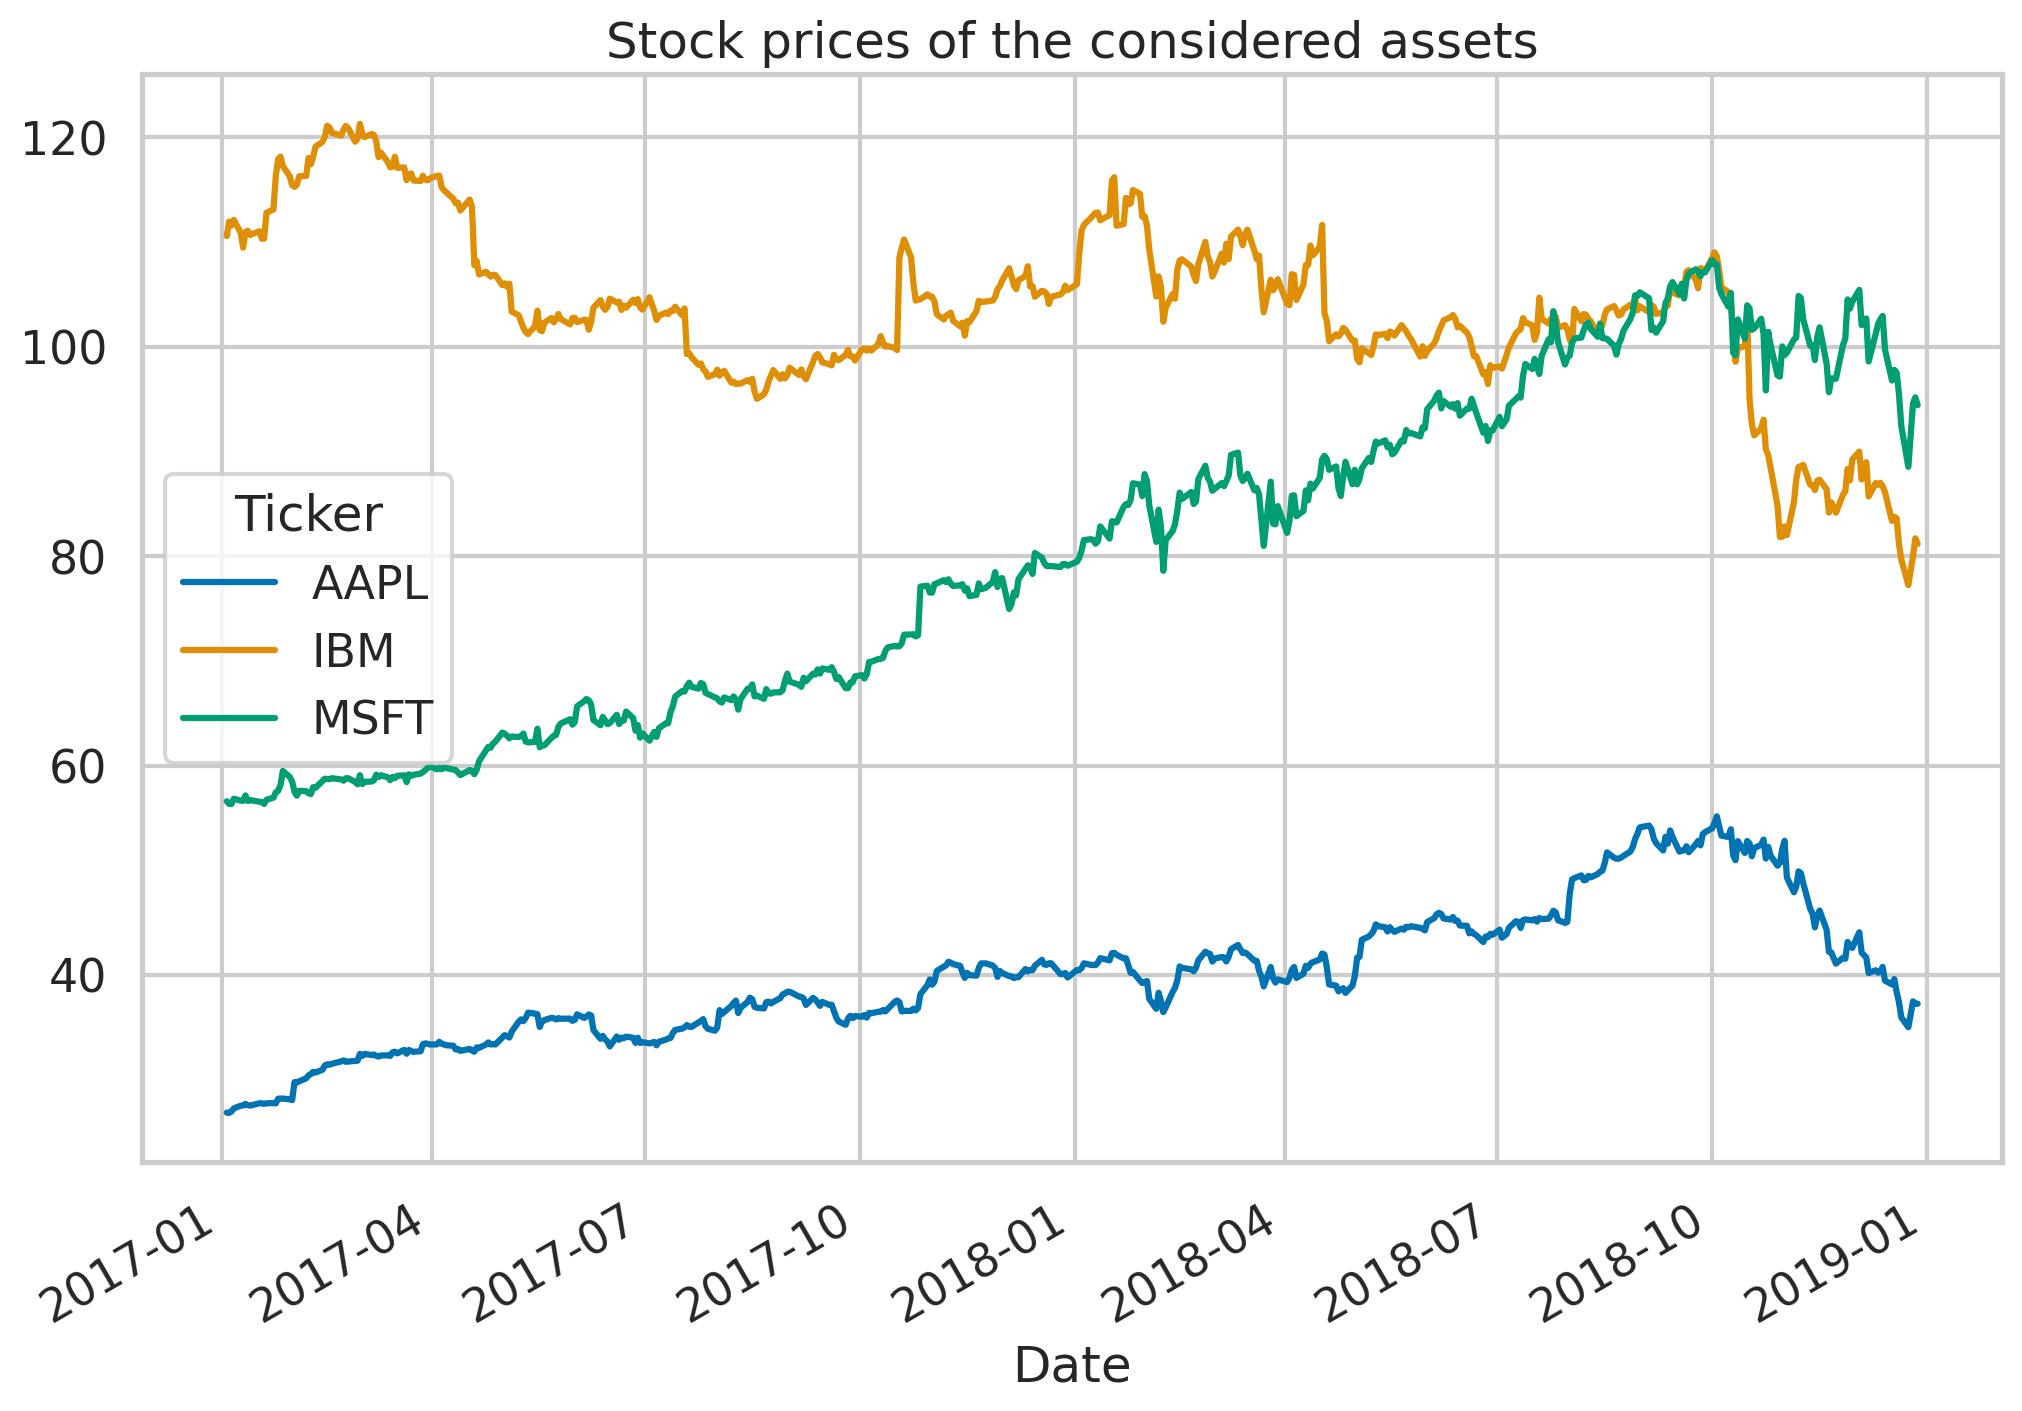

In [ ]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE,
                        end=END_DATE)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
prices_df['Close'].plot(title='Stock prices of the considered assets')

4. Calculate individual asset returns:

In [ ]:
# calculate simple returns, using the adjusted close prices
returns = prices_df['Close'].pct_change().dropna()

In [ ]:
returns.head()

Ticker          AAPL       IBM      MSFT
Date                                    
2017-01-04 -0.001119  0.012381 -0.004474
2017-01-05  0.005085 -0.003309  0.000000
2017-01-06  0.011148  0.004920  0.008668
2017-01-09  0.009159 -0.011090 -0.003183
2017-01-10  0.001009 -0.012705 -0.000319

5. Define the weights:

In [ ]:
portfolio_weights = n_assets * [1 / n_assets]
portfolio_weights

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

Notes:
* List multiplication in Python

In [ ]:
print(4*[1])
print(["A","B"]*2)

[1, 1, 1, 1]
['A', 'B', 'A', 'B']


6. Calculate portfolio returns:

In [ ]:
# matrix multiplication (also known as the dot product—np.dot) of the portfolio weights and a transposed matrix of asset returns
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
                              index=returns.index)

In [ ]:
portfolio_returns

Date
2017-01-04    0.002263
2017-01-05    0.000592
2017-01-06    0.008245
2017-01-09   -0.001704
2017-01-10   -0.004005
                ...   
2018-12-21   -0.029870
2018-12-24   -0.032663
2018-12-26    0.058081
2018-12-27    0.007044
2018-12-28   -0.004629
Length: 500, dtype: float64

Notes:
* `numpy.dot(a, b)`
  * Dot product of two arrays. Specifically,
  * If both a and b are 1-D arrays, it is inner product of vectors (without complex conjugation).
  * If both a and b are 2-D arrays, it is matrix multiplication, but using `matmul` or `a @ b` is preferred.

In [ ]:
print(np.dot(3, 4))
a = [[1, 0], [0, 1]]
b = [[4, 1], [2, 2]]
print(a)
print(b)
print(np.dot(a, b))
print(np.matmul(a,b))

12
[[1, 0], [0, 1]]
[[4, 1], [2, 2]]
[[4 1]
 [2 2]]
[[4 1]
 [2 2]]


7. Create the tear sheet (simple variant):

The preceding line of code generates the simple tear sheet (see https://www.investopedia.com/terms/t/tearsheets.asp) , and the first table looks like this:

In [ ]:
!pip install quantstats

[*********************100%***********************]  5 of 5 completed


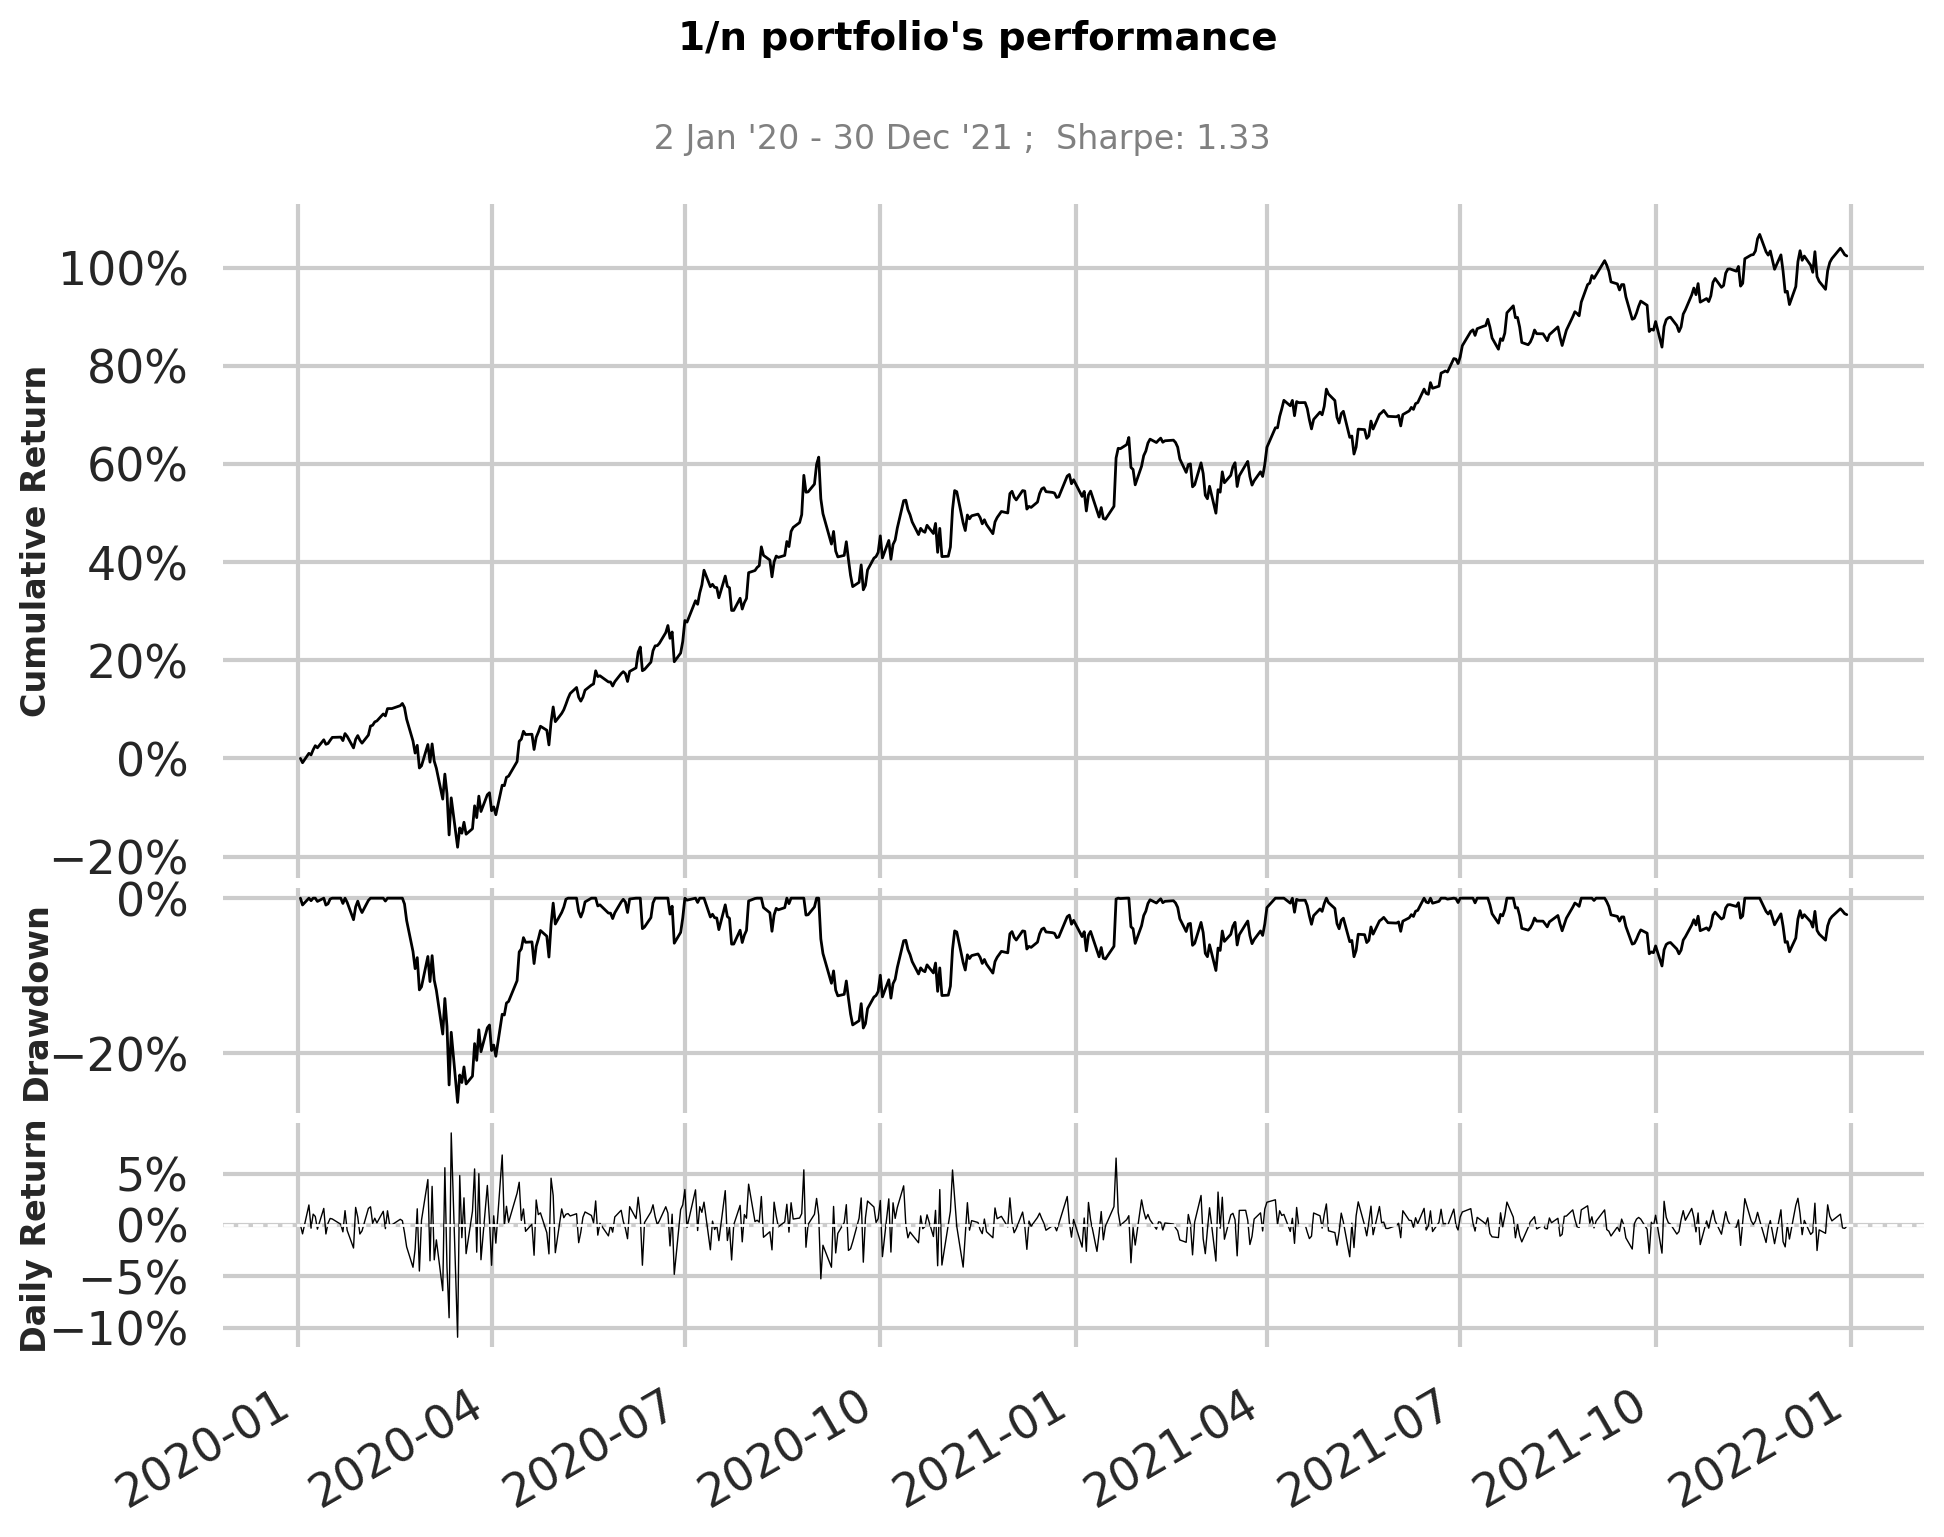

In [ ]:
import quantstats as qs

ASSETS = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]
n_assets = len(ASSETS)
prices_df = yf.download(ASSETS, start="2020-01-01", end="2021-12-31")
returns = prices_df["Close"].pct_change().dropna()
portfolio_weights = n_assets * [1 / n_assets]
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), index=returns.index)
qs.plots.snapshot(portfolio_returns, title="1/n portfolio's performance", grayscale=True)

In [ ]:
qs.reports.metrics(portfolio_returns, benchmark="SPY", mode="basic", prepare_returns=False)

                    Benchmark (SPY)    Strategy
------------------  -----------------  ----------
Start Period        2020-01-03         2020-01-03
End Period          2021-12-30         2021-12-30
Risk-Free Rate      0.0%               0.0%
Time in Market      100.0%             100.0%

Cumulative Return   52.45%             104.18%
CAGR﹪              15.74%             28.07%

Sharpe              0.96               1.34
Prob. Sharpe Ratio  90.67%             96.83%
Sortino             1.33               1.93
Sortino/√2          0.94               1.36
Omega               1.27               1.27

Max Drawdown        -33.72%            -26.35%
Longest DD Days     170                140

Gain/Pain Ratio     0.22               0.27
Gain/Pain (1M)      1.6                3.42

Payoff Ratio        0.8                0.84
Profit Factor       1.22               1.27
Common Sense Ratio  0.97               1.2
CPC Index           0.57               0.63
Tail Ratio          0.8                0

In [ ]:
[method for method in dir(qs.stats) if method[0] != "_"]

['adjusted_sortino',
 'autocorr_penalty',
 'avg_loss',
 'avg_return',
 'avg_win',
 'best',
 'cagr',
 'calmar',
 'common_sense_ratio',
 'comp',
 'compare',
 'compsum',
 'conditional_value_at_risk',
 'consecutive_losses',
 'consecutive_wins',
 'cpc_index',
 'cvar',
 'distribution',
 'drawdown_details',
 'expected_return',
 'expected_shortfall',
 'exposure',
 'gain_to_pain_ratio',
 'geometric_mean',
 'ghpr',
 'greeks',
 'implied_volatility',
 'information_ratio',
 'kelly_criterion',
 'kurtosis',
 'max_drawdown',
 'monthly_returns',
 'omega',
 'outlier_loss_ratio',
 'outlier_win_ratio',
 'outliers',
 'payoff_ratio',
 'pct_rank',
 'probabilistic_adjusted_sortino_ratio',
 'probabilistic_ratio',
 'probabilistic_sharpe_ratio',
 'probabilistic_sortino_ratio',
 'profit_factor',
 'profit_ratio',
 'r2',
 'r_squared',
 'rar',
 'recovery_factor',
 'remove_outliers',
 'risk_of_ruin',
 'risk_return_ratio',
 'rolling_greeks',
 'rolling_sharpe',
 'rolling_sortino',
 'rolling_volatility',
 'ror',
 'seren

## How it works...

1. In Steps 1 to 4, we followed the already established approach—imported the libraries, set up the parameters, downloaded stock prices of four US tech companies (Apple, IBM, Microsoft, and Twitter) over the years 2017-2018, and calculated simple returns, using the adjusted close prices.
2. In Step 5, we created a list of weights, each one equal to `1/ n_assets`, where `n_assets` is
the number of assets we want to have in our portfolio. Next, we calculated the portfolio
returns as a matrix multiplication (also known as the dot product—`np.dot`) of the portfolio
weights and a transposed matrix of asset returns. To transpose the matrix, we used the `T` method of a `pandas` DataFrame. Then, we stored the portfolio returns as a `pandas` Series object, because that is the input for the ensuing step.

3. Lastly, we created a tear sheet using `pf.create_simple_tear_sheet`. We decided to use a simple variant, containing the most relevant portfolio metrics and plots.

    The most important metrics that we saw in the preceding table are:

    * **Sharpe ratio**: One of the most popular performance evaluation metrics, it measures the excess return (over the risk-free rate) per unit of standard deviation. When no risk-free rate is provided, the default assumption is that it is equal to 0%. The greater the Sharpe ratio, the better the portfolio's risk-adjusted performance.
    * **Max drawdown**: A metric of the downside risk of a portfolio, it measures the largest peak-to-valley loss (expressed as a percentage) during the course of the investment. The lower the maximum drawdown, the better.
    * **Calmar ratio**: The ratio is defined as the average annual compounded rate of return divided by the maximum drawdown for that same time period. The higher the ratio, the better.
    * **Stability**: Measured as the R-squared of a linear fit to the cumulative log returns. In practice, this means regressing a range of integers (serving as the time index) on cumulative log returns.
    * **Omega ratio**: The probability-weighted ratio of gains over losses for a determined return target threshold (default set to 0). Its main advantage over the Sharpe ratio is that the Omega ratio—by construction—considers all moments of the returns distribution, while the former only considers the first two (mean and variance).
    * **Sortino ratio**: A modified version of the Sharpe ratio, where the standard deviation in the denominator is replaced with downside deviation.
    * **Skew**: Skewness measures the degree of asymmetry, that is, how much is the given distribution (here, of portfolio returns) more skewed than the Normal distribution. Negative skewness (left-skewed distributions) means that large negative returns occur more frequently than large positive ones.
    * **Kurtosis**: Measures extreme values in either of the tails. Distributions with large kurtosis exhibit tail data exceeding the tails of the Gaussian distribution, meaning that large and small returns occur more frequently.
    * **Tail ratio**: The ratio (absolute) between the 95^{th} and 5^{th} percentile of the daily returns. A tail ratio of ~0.8 means that losses are ~1.25 times as bad as profits.
    * **Daily value at risk**: Calculated as $\mu-2\sigma$, where $\mu$ is the average portfolio return over the period, and $\sigma$ the corresponding standard deviation.

    Downside deviation is similar to standard deviation; however, it only considers negative returns—it discards all positive changes from the series. It also allows us to define different levels of minimum acceptable returns (dependent on the investor), and returns below that threshold are used to calculate the downside deviation.
    
    The tear sheet also contains the following plots:
    * **Cumulative returns plot**: It presents the evolution of the portfolio's worth over time.
    * **Rolling Sharpe ratio**: Instead of reporting one number over time, it is also interesting to see how stable the Sharpe ratio was. That is why the following plot presents this metric calculated on a rolling basis, using 6 months' worth of data.
    * **Underwater plot (also known as the underwater equity curve)**: This plot presents the investment from a pessimistic point of view, as it focuses on losses. It plots all the drawdown periods and how long they lasted—until the value rebounded to a new high. One of the insights we can draw from this is how long the periods of losses lasted.

### There's more

Previously, we used the `pf.create_simple_tear_sheet` function, as it already contains a lot of useful metrics. To obtain even more details, we can use the `pf.create_returns_tear_sheet` function.
Some of the interesting new features include:
* A table with the top five drawdown periods: how bad the drawdown was, the peak/valley dates, the recovery date, and the duration. This table complements the analysis of the underwater plot.
* The top five drawdown periods are also visualized on a separate plot.
* Plots describing the distribution of the portfolio returns: a summary of what the returns were over certain months/years, how the monthly returns were distributed, and the returns' quantiles, using different frequencies. All that information is presented below.

In [ ]:
#pip uninstall pyfolioY

In [ ]:
#pip install git+https://github.com/quantopian/pyfolio

`pyfolio` was developed by the Quantopian team and works really well as a standalone library. However, it can also be combined with `zipline` —a Quantopian-developed backtesting and live-trading framework. Similarly to `backtrader`, it is a framework facilitating backtesting of trading strategies. When we add extra information (such as transaction/position details obtained from `zipline`) to the `pyfolio` function calls, we receive even more information in the tear sheet.

We can create Bayesian tear sheets by running the `pf.create_bayesian_tear_sheet` function. These are based on PyMC3 and require additional dependencies.

Most of the performance/risk metrics presented in the `pyfolio` tear sheets are actually calculated using a library called `empyrical`, also developed by Quantopian. We can use it directly if we are only interested in calculating a specific metric, such as the Omega ratio.    

## See also
Additional resources are available here:
* DeMiguel, V., Garlappi, L., and Uppal, R. (2007). Optimal versus naive diversification: How inefficient is the 1/N portfolio strategy? The Review of Financial Studies, 22(5), 1915-1953.
* Quantopian's website: https://www.quantopian.com/

## Finding the Efficient Frontier using Monte Carlo simulations

According to the Modern Portfolio Theory, the Efficient Frontier is a set of optimal portfolios in the risk-return spectrum. This means that the portfolios on the frontier:

* Offer the highest expected return for a given level of risk
* Offer the lowest level of risk for a given level of expected returns

All portfolios located under the Efficient Frontier curve are considered sub-optimal, so it is always better to choose the ones on the frontier instead.

In this recipe, we show how to find the Efficient Frontier using Monte Carlo simulations. We build thousands of portfolios, using randomly assigned weights, and visualize the results. To do so, we use the returns of four US tech companies from 2018.

### How to do it...

1. Import the libraries:

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd

2. Set up the parameters:

In [ ]:
# the number of simulations
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
RISKY_ASSETS = ['META', 'TSLA', 'NVDA', 'MSFT']
# Sort the list in ascending order
RISKY_ASSETS.sort()
# the considered timeframe
START_DATE = '2024-01-01'
END_DATE = '2024-12-31'

n_assets = len(RISKY_ASSETS)
prices_df = yf.download(RISKY_ASSETS, start=START_DATE,
                        end=END_DATE)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  4 of 4 completed

Downloaded 251 rows of data.


Notes:
* `list.sort()`
    * Sort the list in ascending order and return None.
    * Sort is in-place (the list itself is modified) and stable (the order of two equal elements is maintained)

Remarks:
* `RISKY_ASSETS.sort()` is to sort the list alphabetically. This matters when interpreting the results as when downloading data from Yahoo Finance using the `yfinance` library, the obtained prices are ordered alphabetically, not as specified in the provided list.

3. Download the stock prices from Yahoo Finance:

In [ ]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE,
                        end=END_DATE)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  4 of 4 completed

Downloaded 251 rows of data.


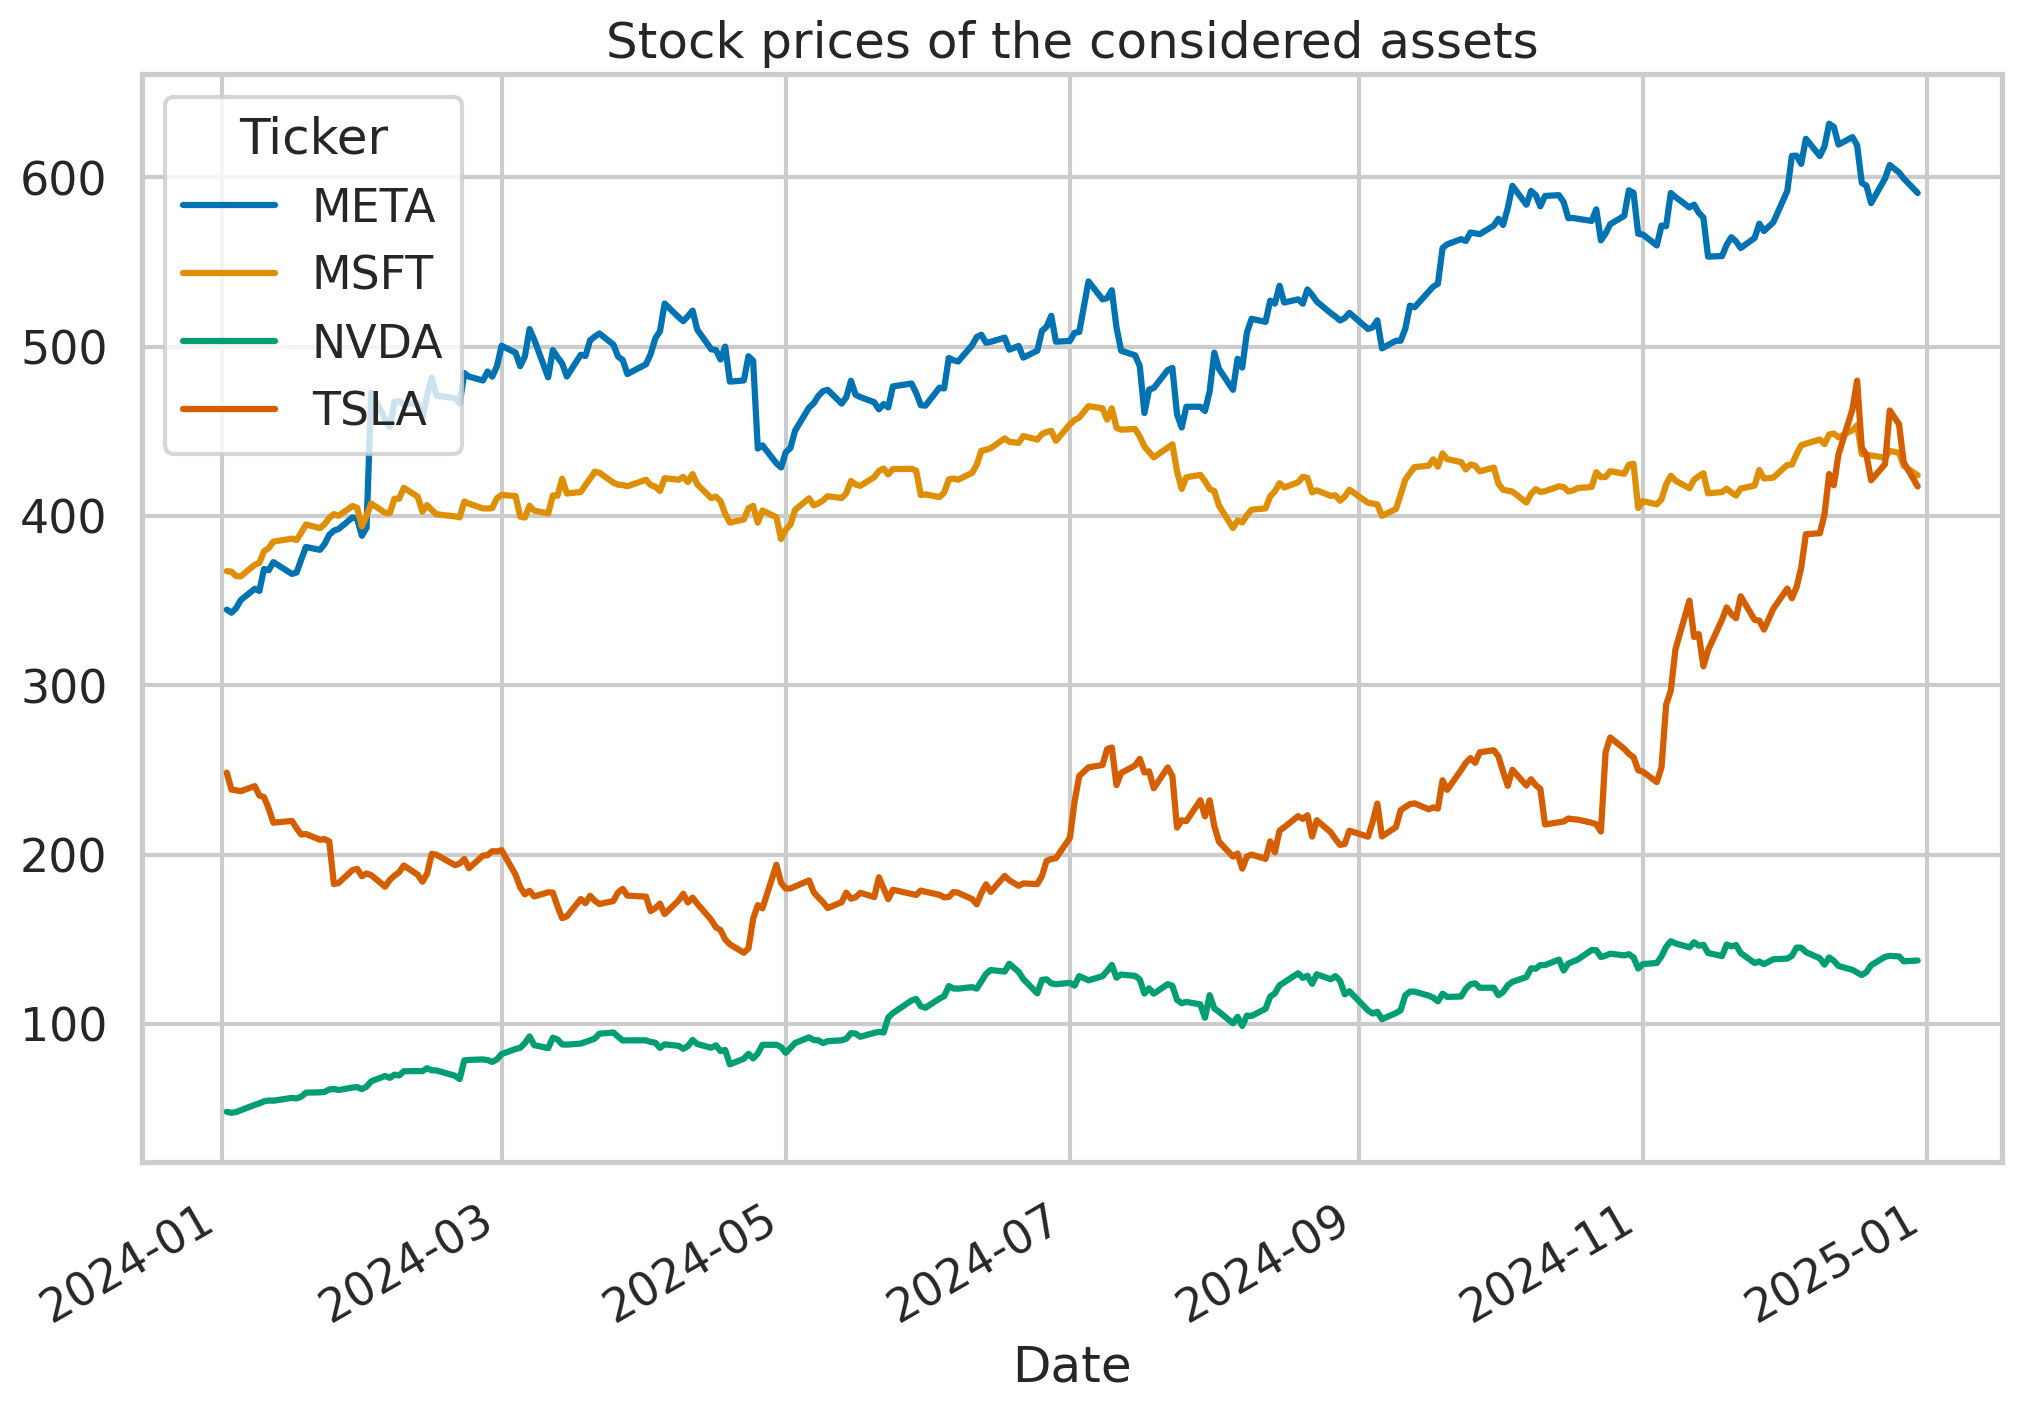

In [ ]:
prices_df['Close'].plot(title='Stock prices of the considered assets');

4. Calculate annualized average returns and the corresponding standard deviation:

In [ ]:
# calculate the simple returns
returns_df = prices_df['Close'].pct_change().dropna()
# annualize the metrics by multiplying them by 252 (the average number of trading days in a year)
# calculate the average (expected) annual return
avg_returns = returns_df.mean() * N_DAYS
# calculate the covariance matrix
cov_mat = returns_df.cov() * N_DAYS

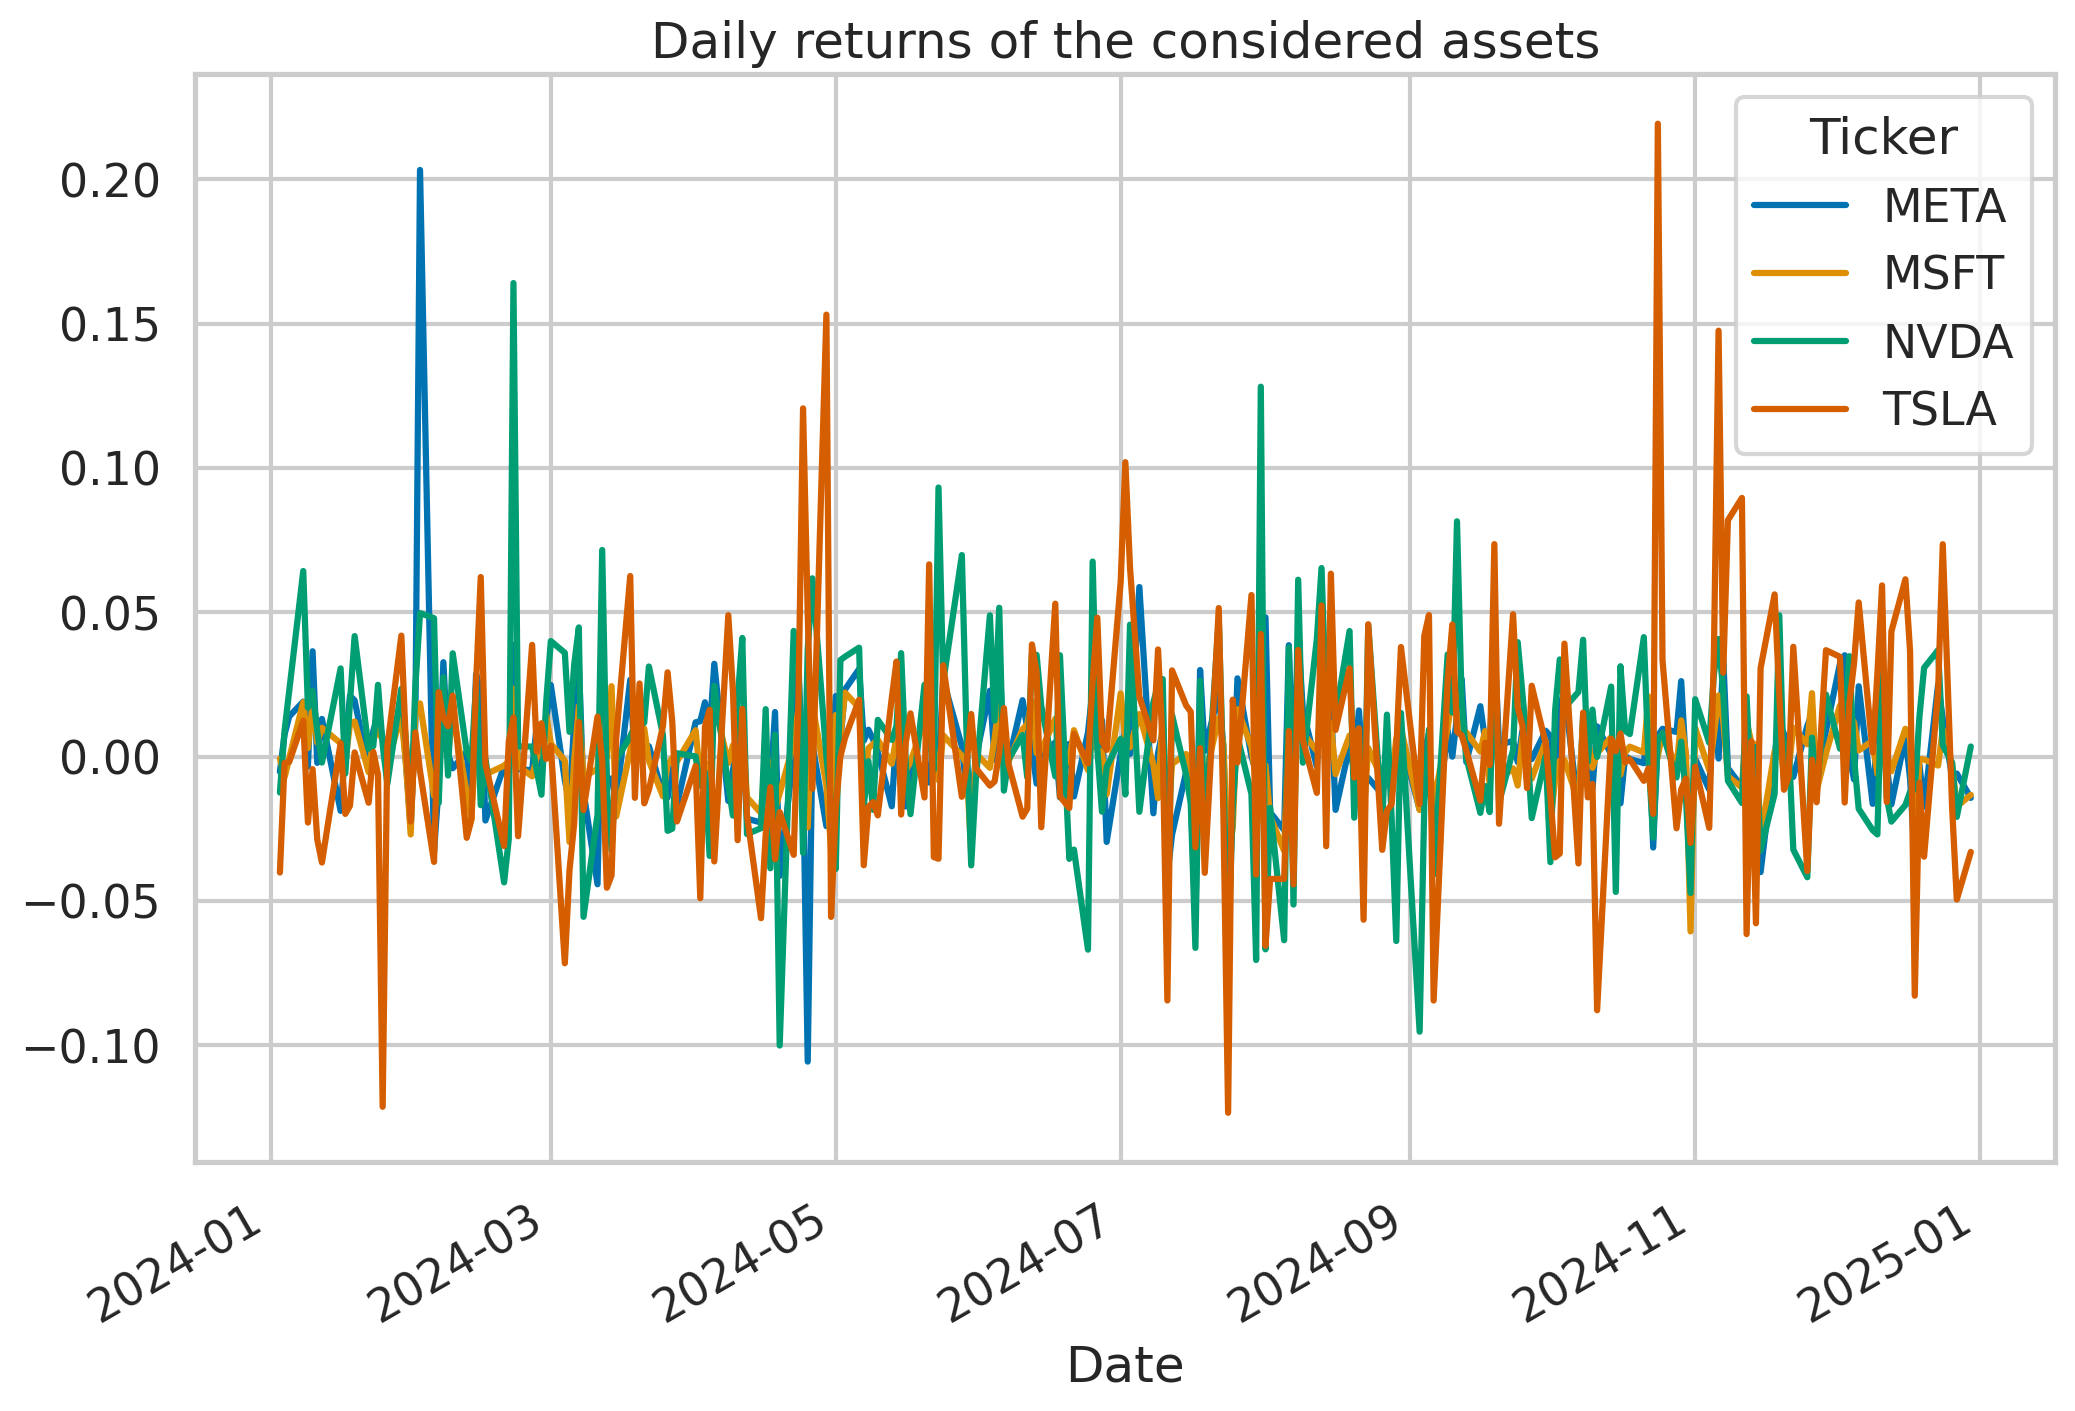

In [ ]:
returns_df.plot(title='Daily returns of the considered assets');

5. Simulate random portfolio weights:

In [ ]:
np.random.seed(42)
# make the weights to be positive and sum up to 1
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [ ]:
weights

array([[0.14102156, 0.35796222, 0.27560979, 0.22540643],
       [0.12620081, 0.1261813 , 0.04698284, 0.70063506],
       [0.2613905 , 0.30790022, 0.00895102, 0.42175826],
       ...,
       [0.24844023, 0.35095292, 0.34779874, 0.05280811],
       [0.26525555, 0.15257129, 0.28992551, 0.29224765],
       [0.12145388, 0.25651504, 0.39812299, 0.22390809]])

Notes:
* Augmented assignment statements
    * An augmented assignment is generally used to replace a statement where an operator takes a variable as one of its arguments and then assigns the result back to the same variable. Similar constructions are often available for various binary operators.

In [ ]:
x, y = 1 , 1
x += 1
print(x)

y = y + (1)
print(y)

2
2


Notes:
* `np.newaxis`
    * The `np.newaxis` is just an alias for the Python constant None, which means that wherever you use `np.newaxis` you could also use `None`
    * The `np.newaxis` is generally used with slicing. It indicates that you want to add an additional dimension to the array. The position of the `np.newaxis` represents where you want to add dimensions.
    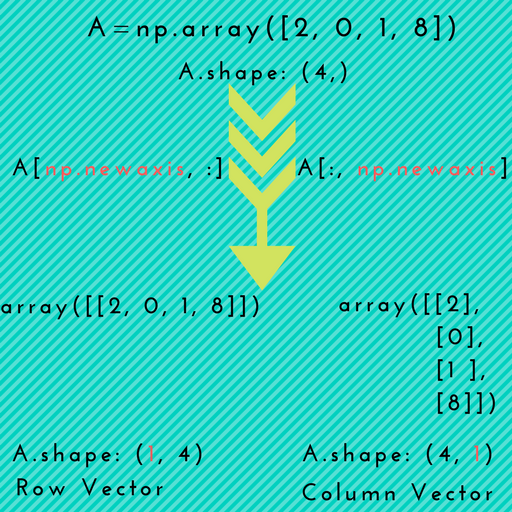

(see https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it)


In [ ]:
example = np.arange(10)
print(example)
print(example.shape,'\n')
print(example[:, np.newaxis])
print(example[:, np.newaxis].shape)

[0 1 2 3 4 5 6 7 8 9]
(10,) 

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
(10, 1)


6. Calculate portfolio metrics:

In [ ]:
# calculate the expected annual portfolio returns
portf_rtns = np.dot(weights, avg_returns)

# calculate the standard deviation, iterate over all the simulated portfolios
portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T,
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_rtns / portf_vol # assume risk-free rate is 0%

Remarks:
* The `for` loop implementation is actually faster than the vectorized matrix equivalent: `np.diag(np.sqrt(np.dot(weights, np.dot(cov_mat, weights.T))))`. The reason for that is the quickly increasing number of off-diagonal elements to be calculated, which, in the end, does not matter for the metrics of interest. This approach is faster than the `for` loop for only a relatively small number of simulations (~100).

7. Create a joint DataFrame with all data:

In [ ]:
# put all the relevant metrics into a pandas DataFrame
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

8. Locate the points creating the Efficient Frontier:

In [ ]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

# create an array of expected returns from the sample
portf_rtns_ef = np.linspace(portf_results_df.returns.min(),
                            portf_results_df.returns.max(),
                            N_POINTS)
# round the numbers to two decimals
portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    # find the minimum observable volatility for each expected return
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

Notes:
* `numpy.delete(arr, obj)`
    * Return a new array with sub-arrays along an axis deleted. For a one dimensional array, this returns those entries not returned by `arr`.
    * `arr` : *array_like*. Input array.
    * `obj` : *slice, int or array of ints*. Indicate indices of sub-arrays to remove along the specified axis.

In [ ]:
# np.delete
example = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
exampleindex = [2, 3, 6]

np.delete(example, exampleindex)

array([1, 2, 5, 6, 8, 9])

9. Plot the Efficient Frontier:

<ipython-input-118-5e09352b8ba3>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=avg_returns[asset_index],


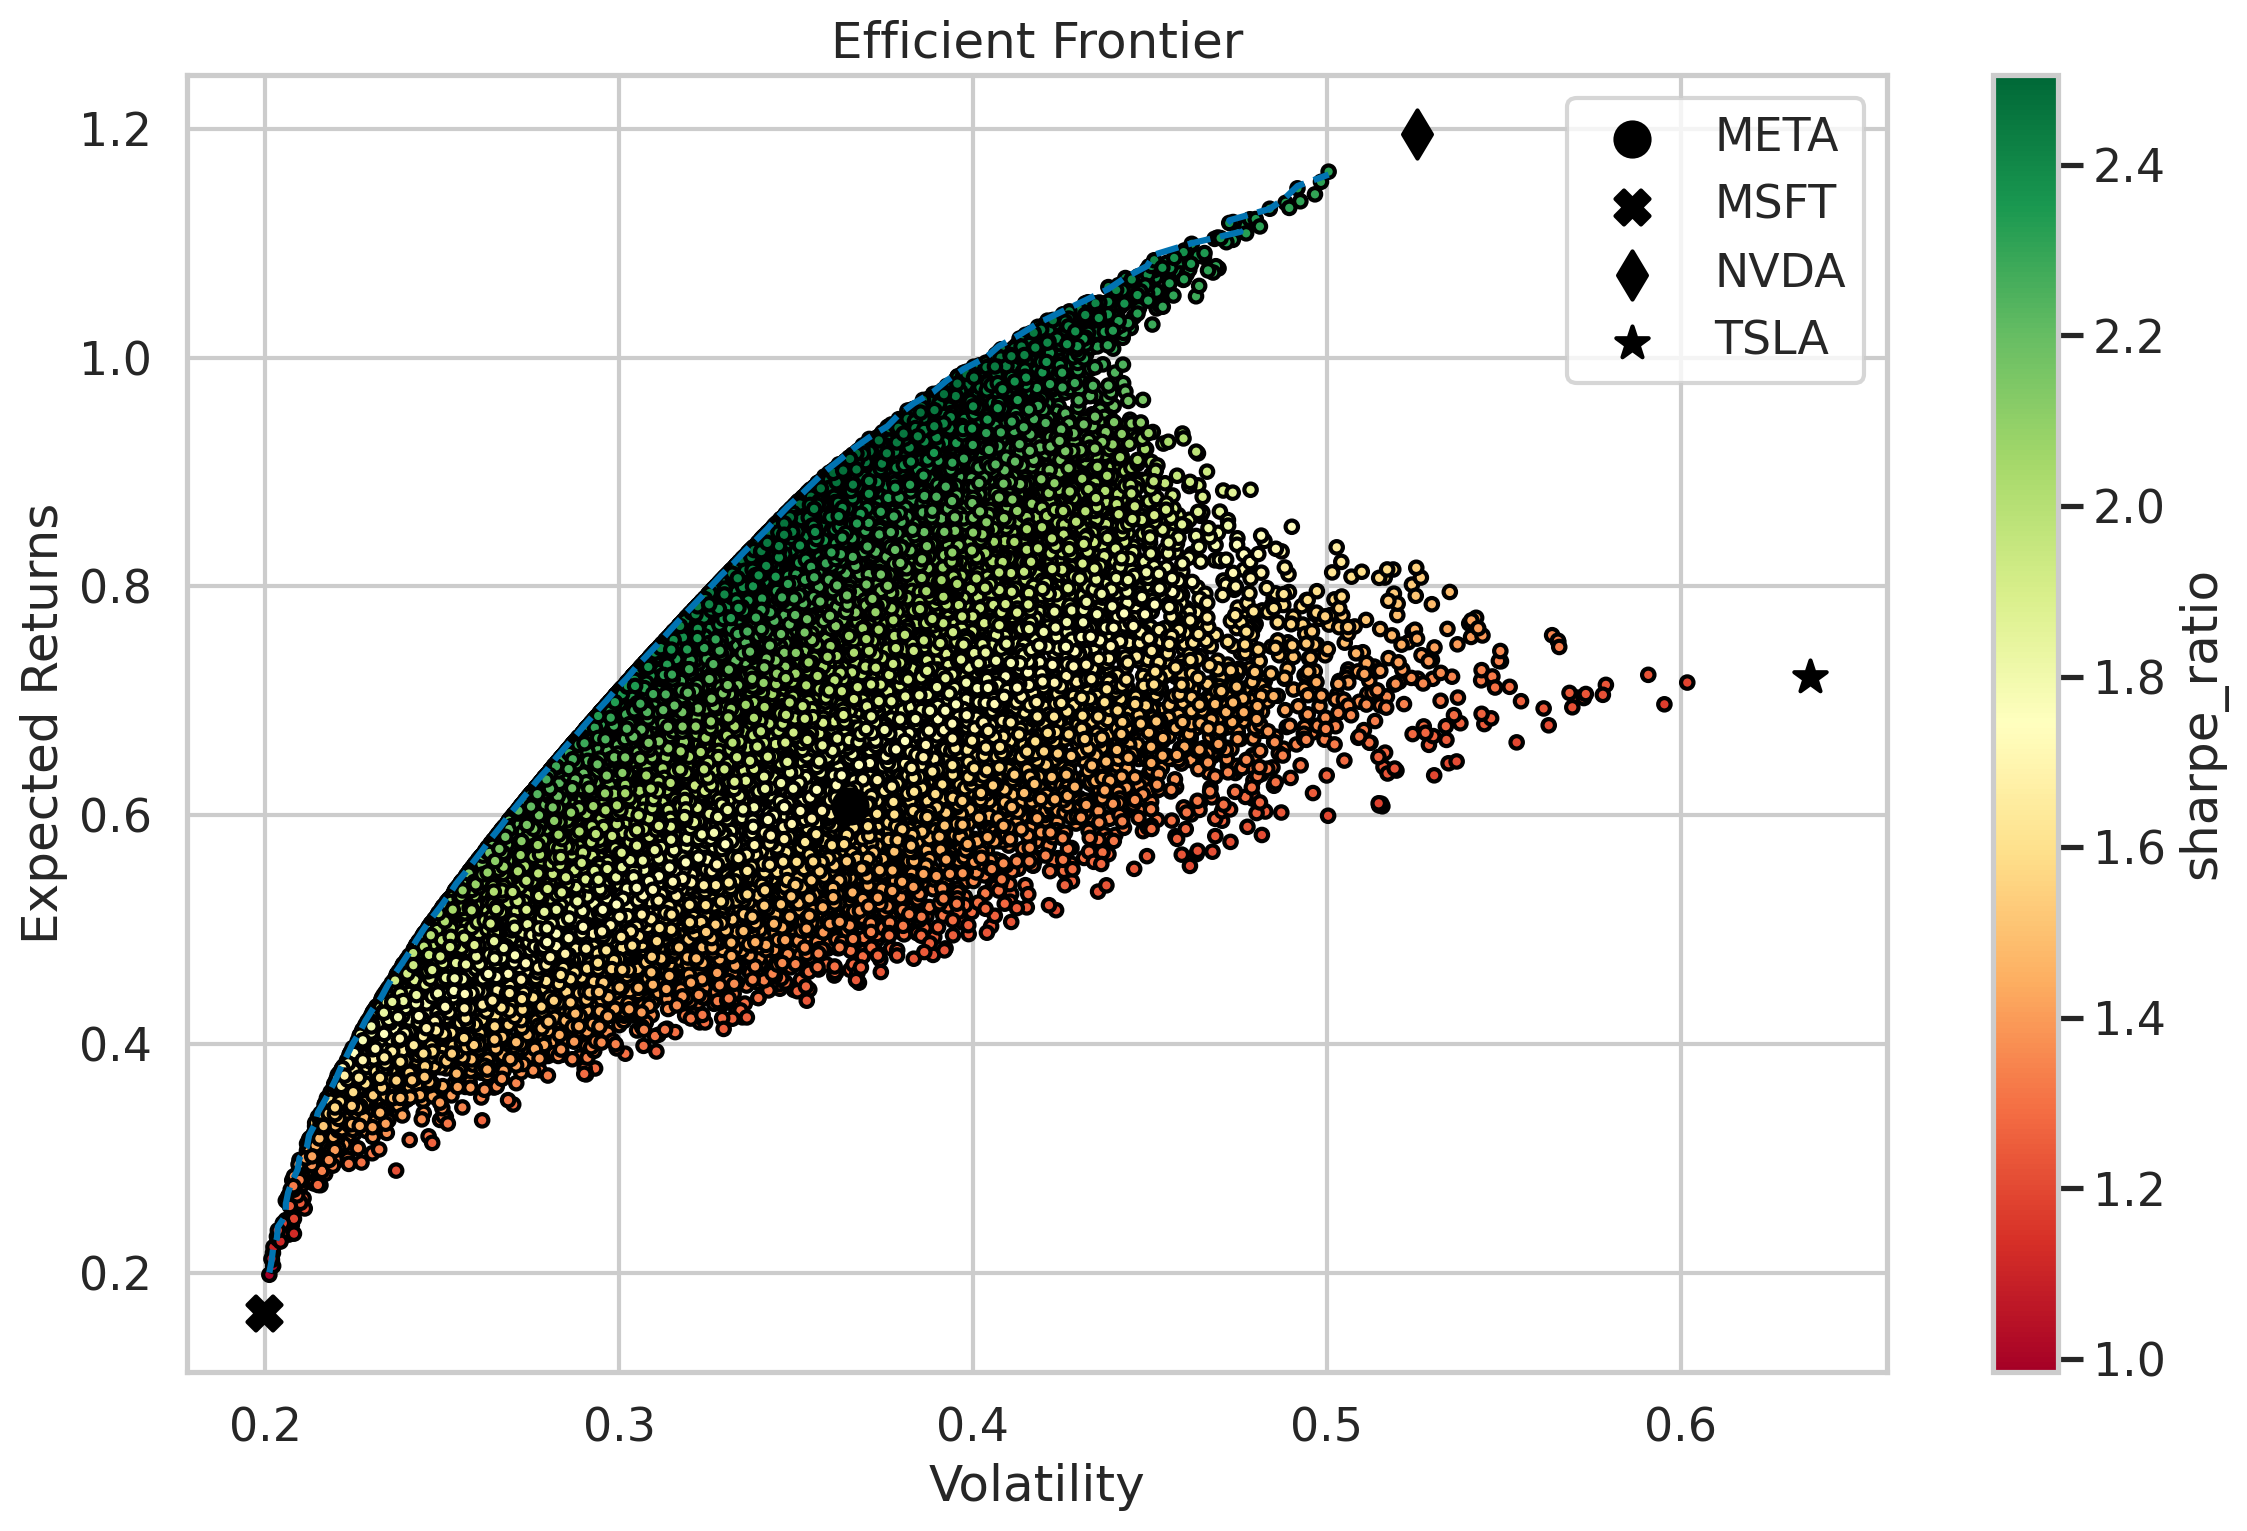

In [ ]:
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
# plot dots representing the simulated portfolios
portf_results_df.plot(kind='scatter', x='volatility',
                      y='returns', c='sharpe_ratio', # color the by the value of the Sharpe ratio
                      cmap='RdYlGn', edgecolors='black',
                      ax=ax)
# add labels
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')

# plot the approximated Efficient Frontier
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')

# plot the individual assets
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
               y=avg_returns[asset_index],
               marker=MARKS[asset_index],
               s=150,
               color='black',
               label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

Executing the preceding code generates the plot with all the randomly created portfolios, four points indicating the individual assets, and the Efficient Frontier.


In the preceding plot, we see the typical, bullet-like shape of the Efficient Frontier.

Summary:

1. In Step 2, we defined parameters used for this recipe, such as the considered timeframe, the risky assets we wanted to use for building the portfolio, and the number of simulations. Having downloaded the stock prices, we calculated simple returns using the `pct_change` method of a `pandas` DataFrame, and dropped the first row containing NaNs.

    For evaluating the potential portfolios, we needed the average (expected) annual return and the corresponding covariance matrix. We obtained them by using the `mean()` and `cov()` methods of the DataFrame. We also annualized both metrics by multiplying them by 252 (the average number of trading days in a year).
    
    We needed the covariance matrix, as for calculating the portfolio volatility, we also needed to account for the correlation between the assets. To benefit from significant diversification, the assets should have low positive or negative correlations.
    
2. In Step 5, we calculated the random portfolio weights. Following the assumptions of the MPT (refer to the chapter introduction for reference), the weights needed to be positive and sum up to 1. To achieve this, we first generated a matrix of random numbers (between 0 and 1), using `np.random.random.` The matrix was of size `N_SIMULATIONS x N_ASSETS`. To make sure the weights totaled 1, we divided each row of the matrix by its sum.

3. In Step 6, we calculated the portfolio metrics—returns and standard deviation. To calculate the expected annual portfolio returns, we had to multiply the weights by the previously calculated annual averages. For the standard deviations, we had to use the following formula:
$\omega^T\sum{\omega}$, where $\omega$ is the vector of weights and $\sum$ is the historical covariance matrix. To calculate the standard deviation, we iterated over all the simulated portfolios, using a `for` loop.

    For this example, we assumed that the risk-free rate was 0%, so the Sharpe ratio of the portfolio could be calculated as portfolio returns/portfolio volatility. Another possible approach would be to calculate the average annual risk-free rate over 2018, and to use the portfolio excess returns for calculating the ratio.

4. The last three steps led to visualizing the results. First, we put all the relevant metrics into a `pandas` DataFrame. Second, we created an array of expected returns from the sample. To do so, we used `np.linspace`, with the min and max values from the calculated portfolio returns. We rounded the numbers to two decimals, to make the calculations smoother. For each expected return, we found the minimum observable volatility. In cases where there was no match, as can happen with equally spread points on the linear space, we skipped that point.

5. In the very last step, we plotted the simulated portfolios, the individual assets, and the approximated Efficient Frontier in one plot. The shape of the frontier was a bit jagged, which can be expected when using only simulated values that are not that frequent in some extreme areas. Additionally, we colored the dots representing the simulated portfolios by the value of the Sharpe ratio.


Remarks:

* You can find the available colormaps here: https://matplotlib.org/examples/color/colormaps_reference.html. Depending on the problem at hand, a different colormap might be more suitable (sequential, diverging, qualitative, and so on).

### There's more

Having simulated 100,000 random portfolios, we can also investigate which one has the highest Sharpe ratio (maximum expected return per unit of risk, also known as the **Tangency Portfolio**) or minimum volatility. To locate these portfolios among the simulated ones, we use `np.argmin` and `np.argmax`, which return the index of a minimum/maximum value in the array.

In [ ]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

Notes:
* `numpy.argmin(array)`

In [ ]:
# np.argmin()
example = [3,2,5]
np.argmin(example)

np.int64(1)

In [ ]:
# investigate the constituents of these portfolios
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="")
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="")

Maximum Sharpe Ratio portfolio ----
Performance
returns: 92.89% volatility: 37.07% sharpe_ratio: 250.55% 
Weights
META: 33.32% MSFT: 0.07% NVDA: 51.78% TSLA: 14.82% 

The maximum Sharpe ratio portfolio allocates the majority of the resources (~75%) to Microsoft and virtually nothing to Facebook. That is because Facebook's annualized average returns for 2018 were negative.

Notes:
* `print(value, ..., sep=' ', end='\n')`
    * Prints the values to a stream.
    * `sep`: string inserted between values, default a space.
    * `end`: *Optional*. String appended after the last value. Default is '\n' (line feed)

In [ ]:
print('Hello','World',sep=' ',end='!')

Hello World!

In [ ]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="")
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="")

Minimum Volatility portfolio ----
Performance
returns: 19.81% volatility: 20.12% sharpe_ratio: 98.46% 
Weights
META: 2.60% MSFT: 95.17% NVDA: 2.04% TSLA: 0.19% 

The minimum volatility portfolio assigns ~79% of the weight to Microsoft, as it is the stock with the lowest volatility (this can be inspected by viewing the covariance matrix).

Lastly, we mark these two portfolios on the Efficient Frontier plot. To do so, we add two extra scatterplots, each with one point corresponding to the selected portfolio. We then define the marker shape with the `marker` argument, and the marker size with the `s` argument. We increase the size of the markers to make the portfolios more visible among all others.

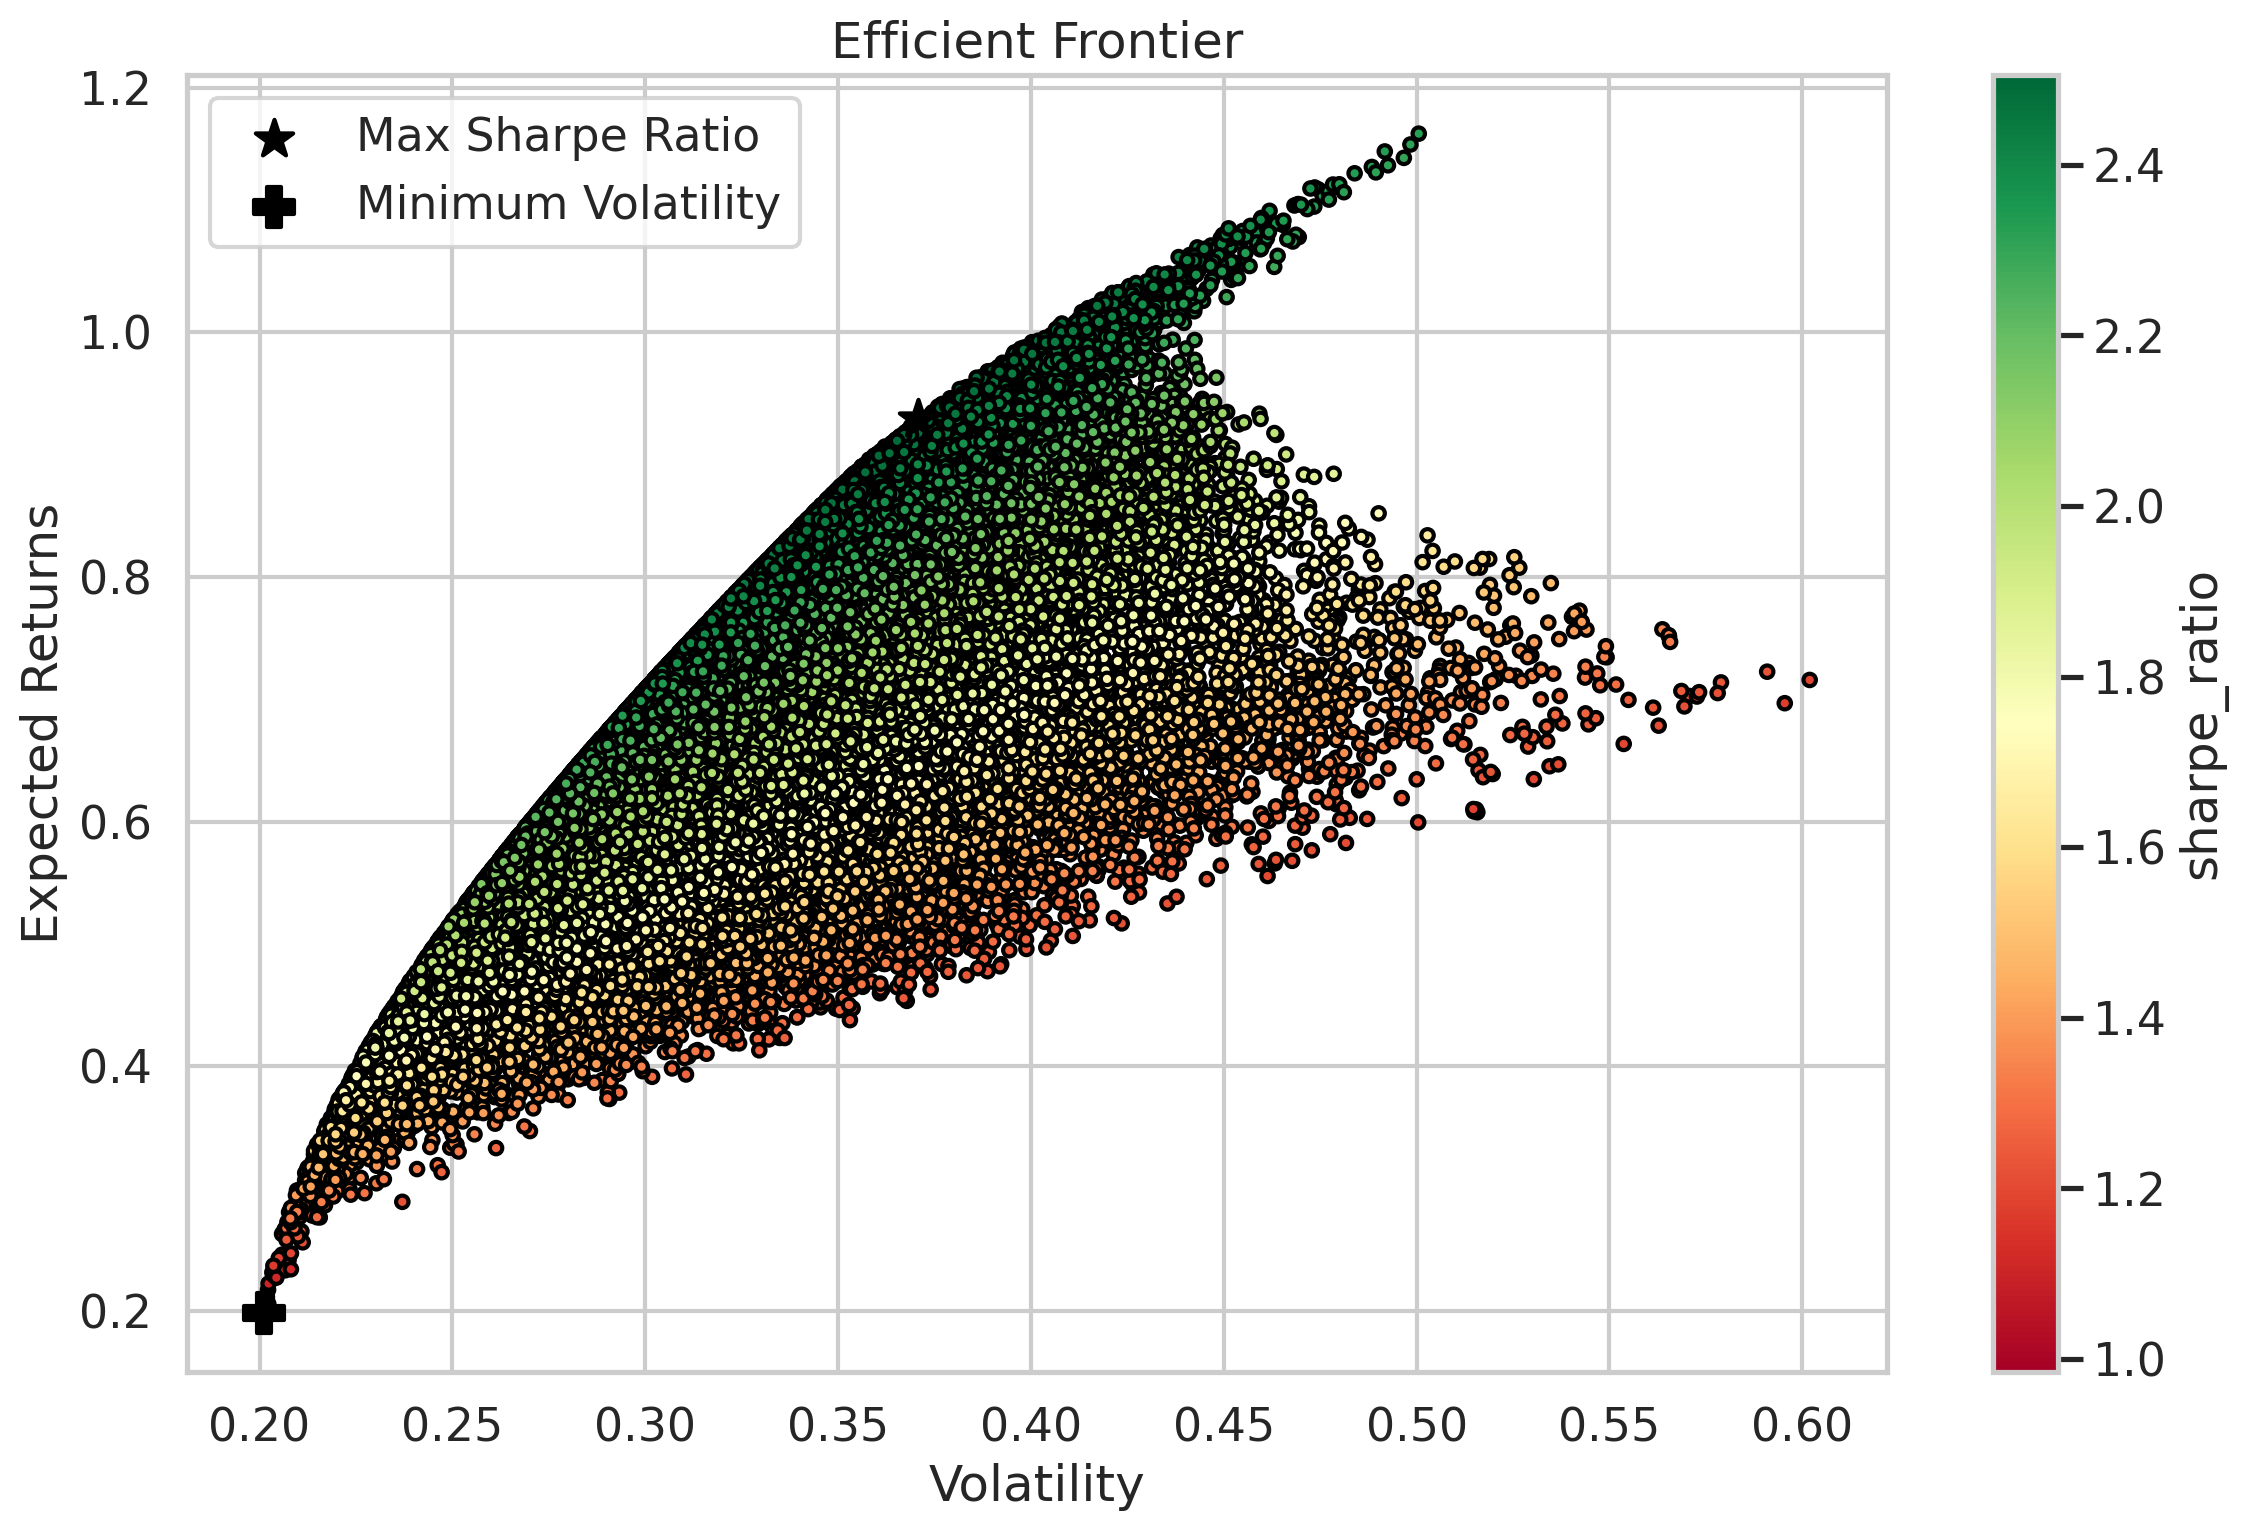

In [ ]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black',
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility,
           y=max_sharpe_portf.returns,
           c='black', marker='*',
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility,
           y=min_vol_portf.returns,
           c='black', marker='P',
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns',
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
plt.show()

We did not plot the individual assets and the Efficient Frontier's line, to avoid the plot becoming too cluttered.

## Finding the Efficient Frontier using optimization with scipy

In the previous recipe, *Finding the Efficient Frontier using Monte Carlo simulations*, we used a brute-force approach based on Monte Carlo simulations to visualize the Efficient Frontier. In this recipe, we use a more refined method to determine the frontier.

From its definition, the Efficient Frontier is formed by a set of portfolios offering the highest expected portfolio return for a certain volatility, or offering the lowest risk (volatility) for a certain level of expected returns. We can leverage this fact, and use it in numerical optimization. The goal of optimization is to find the best (optimal) value of the objective function by adjusting the target variables and taking into account some boundaries and constraints (which have an impact on the target variables). In this case, the objective function is a function returning portfolio volatility, and the target variables are portfolio weights.

Mathematically, the problem can be expressed as:<center>min $\omega^T\sum{\omega}$<br>$s.t.$ &ensp; $\omega^T\boldsymbol 1 =1$<br>$\omega \geq 0$ <br>$\omega^T\mu=\mu_p$ </center>



Here, $\omega$ is a vector of weights, $\sum$ is the covariance matrix, $\mu$ is a vector of returns, and $\mu_p$ is the expected portfolio return.

We iterate the optimization routine used for finding the optimal portfolio weights over a range of expected portfolio returns, and this results in the Efficient Frontier.

In this recipe, we work with the same dataset as in the previous one, in order to show that the results obtained by both approaches are similar

### Getting Ready

This recipe requires running all the code from the recipe *Finding the Efficient Frontier using Monte Carlo simulations* recipe to be run.

### How to do it...

1. Import the libraries:

In [ ]:
import numpy as np
import scipy.optimize as sco

Notes:
* SciPy `optimize` module provides functions for minimizing (or maximizing) objective functions, possibly subject to constraints. It includes solvers for nonlinear problems (with support for both local and global optimization algorithms), linear programing, constrained and nonlinear least-squares, root finding, and curve fitting.

2. Define functions calculating portfolio returns and volatility:

In [ ]:
# return the expected portfolio return
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

# return the expected portfolio volatility
def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

Remarks:
* We had to define these functions instead of calculating these metrics directly, as we used them in the optimization procedure. The algorithm iteratively tries different weights and needs to be able to use the current values of the target variables (weights) to arrive at the metric it tries to optimize. The function we optimize must accept the arguments as inputs.

3. Define the function calculating the efficient frontier:

In [ ]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):

    efficient_portfolios = []

    n_assets = len(avg_returns)
    # arguments for objective function
    args = (avg_returns, cov_mat) # historial average returns and the covariance matrix
    # bounds for each target variable (weight)
    bounds = tuple((0,1) for asset in range(n_assets)) # a tuple with four identical elements (0,1)
    # initial guess for each target variable
    initial_guess = n_assets * [1. / n_assets, ]

    for ret in rtns_range:
        constraints = ({'type': 'eq',
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret}, # the expected porfolio return equal to the provide value
                       {'type': 'eq',
                        'fun': lambda x: np.sum(x) - 1}) # the sum of the weights equals to 1
        # find the optimal risk level
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess,
                                           args=args, method='SLSQP',
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)

    return efficient_portfolios

Remarks:
* The optimizer sets the equality (eq) constraint to 0. That is why the intended constraint, `np.sum(weights) == 1`, is expressed as `np.sum(weights) - 1 == 0`.


Notes:
* `scipy.optimize.minimize(fun, x0, args=(), method=None, constraints=())`
    * Minimization of scalar function of one or more variables.
    * `fun` : *callable*. The objective function to be minimized.
    * `x0` : *ndarray, shape (n,)*. Initial guess. Array of real elements of size (n,),where 'n' is the number of independent variables.
    * `args` : *tuple*, optional. Extra arguments passed to the objective function and its derivatives (`fun`, `jac` and `hess` functions).
    * `method` : *str* or callable, optional. Type of solver.
    * `constraints` : *{Constraint, dict}* or List of *{Constraint, dict}*, optional. Constraints definition (only for COBYLA, SLSQP and trust-constr). Constraints for COBYLA, SLSQP are defined as a list of dictionaries. Each dictionary with fields:
        * `type`: *str*. Constraint type: ‘eq’ for equality, ‘ineq’ for inequality.
        * `fun`: *callable*. The function defining the constraint.
    * https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

4. Define the considered range of returns:

In [ ]:
rtns_range = np.linspace(-0.22, 0.32, 200) # based on the experience from the previous recipe

5. Calculate the Efficient Frontier:

In [ ]:
# run the optimization function
efficient_portfolios = get_efficient_frontier(avg_returns,
                                              cov_mat,
                                              rtns_range)

6. Extract the volatilities of the efficient portfolios:

In [ ]:
vols_range = [x['fun'] for x in efficient_portfolios]

In [ ]:
efficient_portfolios

[ message: Positive directional derivative for linesearch
  success: False
   status: 8
      fun: 0.19971366683407898
        x: [ 4.473e-13  1.000e+00  6.934e-17  2.456e-13]
      nit: 8
      jac: [ 2.083e-01  1.997e-01  2.405e-01  1.911e-01]
     nfev: 34
     njev: 4,
  message: Positive directional derivative for linesearch
  success: False
   status: 8
      fun: 0.1997136668339893
        x: [ 2.308e-18  1.000e+00  1.109e-16  1.766e-13]
      nit: 13
      jac: [ 2.083e-01  1.997e-01  2.405e-01  1.911e-01]
     nfev: 115
     njev: 9,
  message: Positive directional derivative for linesearch
  success: False
   status: 8
      fun: 0.1997136668340058
        x: [ 0.000e+00  1.000e+00  1.217e-13  2.986e-14]
      nit: 6
      jac: [ 2.083e-01  1.997e-01  2.405e-01  1.911e-01]
     nfev: 10
     njev: 2,
  message: Positive directional derivative for linesearch
  success: False
   status: 8
      fun: 0.19971366683406547
        x: [ 0.000e+00  1.000e+00  3.936e-13  0.000e+00]
  

Remarks:
* We extracted the volatility from the `scipy.optimize.OptimizeResult` object by accessing the `'fun'` element. This stands for the optimized objective function—in this case, the portfolio volatility.

7. Plot the calculated Efficient Frontier, together with the simulated portfolios:

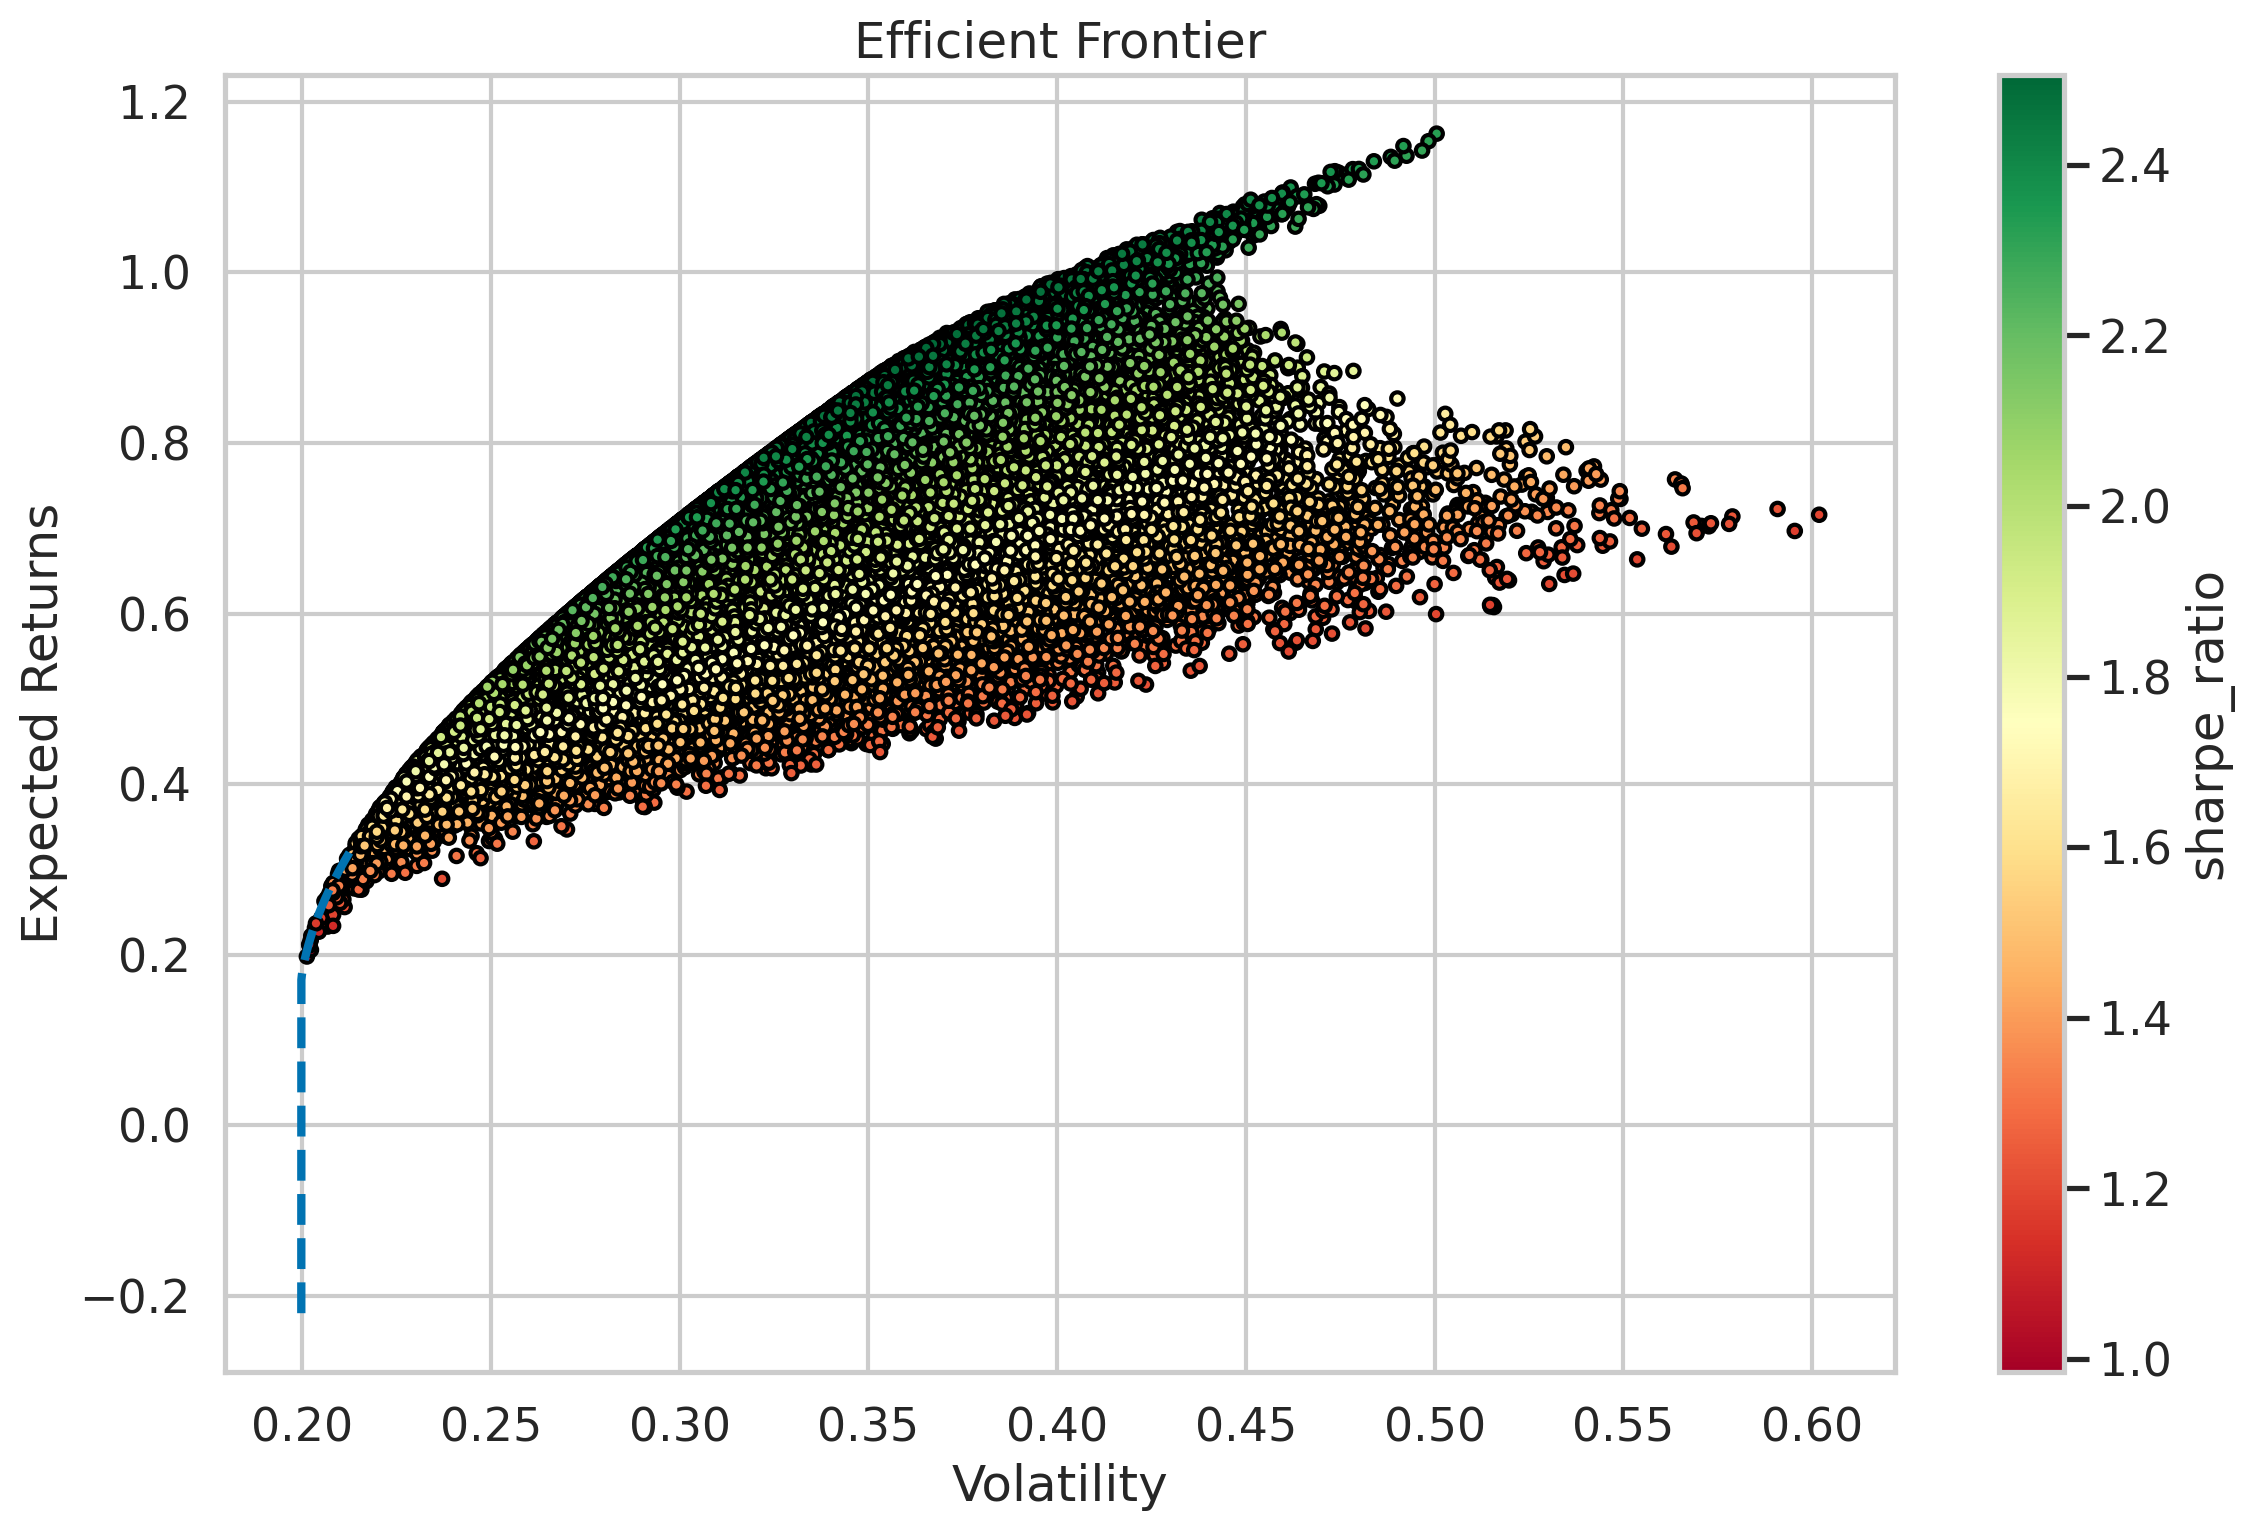

In [ ]:
fig, ax = plt.subplots()
# plot the simulated portfolios from the previous recipe
portf_results_df.plot(kind='scatter', x='volatility',
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black',
                      ax=ax)
# add the calculated Efficient Frontier
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')

plt.tight_layout()
plt.show()

We see that the Efficient Frontier has a very similar shape to the one obtained using Monte Carlo simulations. The only difference is that the line is smoother.

8. Identify the minimum volatility portfolio:

In [ ]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': (min_vol_portf_rtn /
                                  min_vol_portf_vol)}

min_vol_portf

{'Return': np.float64(0.16804020100502517),
 'Volatility': np.float64(0.19969647535849305),
 'Sharpe Ratio': np.float64(0.8414780516449334)}

9. Print performance summary:

In [ ]:
print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="")

print('\nWeights')
# extract the portfolio's weights from the Efficient Frontier
for x, y in zip(RISKY_ASSETS, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="")

Minimum Volatility portfolio ----
Performance
Return: 16.80% Volatility: 19.97% Sharpe Ratio: 84.15% 
Weights
META: 0.00% MSFT: 99.36% NVDA: 0.00% TSLA: 0.64% 

The minimum volatility portfolio is achieved by investing mostly in Microsoft and Facebook, while not investing in Twitter at all.

Summary:

1. As mentioned in the introduction, we continued the example from the previous recipe. That is why we had to run Step 1 to Step 4 from the previous recipe, *Finding the Efficient Frontier using Monte Carlo simulations* (not shown here for brevity), to have all the required data. As an extra prerequisite, we had to import the optimization module from `scipy`.

2. In Step 2, we defined two functions, which returned the expected portfolio return and volatility, given historical data and the portfolio weights.

3. In Step 3, we defined a function called `get_efficient_frontier`. Its goal is to return a list containing the efficient portfolios, given historical metrics and the considered range of returns. This was the most important step of the recipe and contained a lot of nuances.

    We describe the logic of the function sequentially:

* The outline of the function is that it runs the optimization procedure for each expected return in the considered range, and stores the resulting optimal portfolio in a list.
* Outside of the `for` loop, we define a couple of objects that we pass into the optimizer:
    * The arguments that are passed to the objective function. In this case, these are the historical average returns and the covariance matrix. The function that we optimize must accept the arguments as inputs. That is why we pass the returns to the `get_portfolio_volatility` function, even though they are not necessary for calculations.
    * Bounds (a nested tuple)—for each target variable (weight), a tuple containing the boundaries—minimum and maximum allowable values. In this case, the values span the range from 0 to 1 (no negative weights, as per the MPT).
    * `initial_guess`, which is the initial guess of the target variables. The goal of using the initial guess is to make the optimization run faster and more efficiently. In this case, the guess is the 1/n allocation.

* Inside the `for` loop, we define the last element used for the optimization—the constraints. We define two constraints:
    * The expected portfolio return must be equal to the provided value.
    * The sum of the weights must be equal to 1.
    * The first constraint is the reason why the constraint's tuple is defined within the loop—as the loop passes over the considered range of expected portfolio returns, and for each value, we find the optimal risk level.
    * We run the optimizer with the **Sequential Least-Squares Programming (SLSQP)** algorithm, which is frequently used for generic minimization problems. For the function to be minimized, we pass the specially prepared `get_portfolio_volatility` function.

4. In Steps 4 and 5, we defined the range of expected portfolio returns (based on the range we empirically observed in the previous recipe) and ran the optimization function.
    
5. In Step 6, we iterated over the list of efficient portfolios and extracted the optimal volatilities.

6. In Step 7, we added the calculated Efficient Frontier on top of the plot from the previous recipe, *Finding the Efficient Frontier using Monte Carlo simulations*. All the simulated portfolios lie on or below the Efficient Frontier, which is what we expected to happen.
    
7. In Steps 8 and 9, we identified the minimum volatility portfolio, printed the performance metrics, and showed the portfolio's weights (extracted from the Efficient Frontier).

We can now compare the two minimum volatility portfolios: the one obtained using Monte Carlo simulations, and the one we received from optimization. The prevailing pattern in the allocation is the same—allocate the majority of the available resources to Facebook and Microsoft. We can also see that the volatility of the optimized strategy is slightly lower. This means that among the 100,000 portfolios, we have not simulated the actual minimum volatility portfolio.

### There's more

We can also use the optimization approach to find the weights that generate a portfolio with the highest expected Sharpe ratio—the Tangency Portfolio. To do so, we first need to define the objective function, which is the negative of the Sharpe ratio. The reason why we use the negative is that the optimization algorithms run minimization problems. We can easily approach the maximization problems by changing the sign of the objective metric:

1. Define the objective function:

In [ ]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

The second step is very similar to what we have already done with the Efficient Frontier, this time without the `for` loop, as we are only searching for one set of weights. We include the risk-free rate in the arguments (though we assume it is 0%, for simplicity) and only use one constraint—the sum of the target variables must be equal to 1.

2. Find the optimized portfolio:

In [ ]:
n_assets = len(avg_returns)
RF_RATE = 0

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq',
                'fun': lambda x: np.sum(x) - 1})  # the sum of the weights equals to 1
bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio,
                                x0=initial_guess,
                                args=args,
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints)

In [ ]:
bounds

((0, 1), (0, 1), (0, 1), (0, 1))

3. Extract information about the maximum Sharpe Ratio portfolio:

In [ ]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w,
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w,
                                                avg_returns,
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}
max_sharpe_portf

{'Return': np.float64(0.9202145842802838),
 'Volatility': np.float64(0.3671366101507275),
 'Sharpe Ratio': np.float64(2.506463694542723)}

4. Print performance summary:

In [ ]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="")

print('\nWeights')
for x, y in zip(RISKY_ASSETS, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="")

Maximum Sharpe Ratio portfolio ----
Performance
Return: 92.02% Volatility: 36.71% Sharpe Ratio: 250.65% 
Weights
META: 35.45% MSFT: 0.00% NVDA: 50.38% TSLA: 14.17% 

The above result contains a summary of the portfolio maximizing the Sharpe ratio.


To achieve maximum Sharpe ratio, the investor should invest mostly in Microsoft and Twitter, with a 0% allocation to Facebook, as Facebook's average return over 2018 was negative.

## Finding the Efficient Frontier using convex optimization with cvxpy

In the previous recipe, *Finding the Efficient Frontier using optimization with scipy*, we found the Efficient Frontier, using numerical optimization with `scipy`. We used the portfolio volatility as the metric we wanted to minimize. However, it is also possible to state the same problem a bit differently and use convex optimization to find the Efficient Frontier.

We can reframe the mean-variance optimization problem into a risk-aversion framework, in which the investor wants to maximize the risk-adjusted return:

<center>max $\omega^T \mu - \gamma \omega^T \sum\omega $</center>
<center>$s.t. \; \; \omega^T \textbf{1}=1$</center>
<center>$\omega \geq 0$</center>

Here, $\gamma \in [0, \infty)$ is the risk-aversion parameter, and the constraints specify that the weights must sum up to 1, and short-selling is not allowed. The higher the value of $\gamma$, the more risk-averse the investor is.

In this recipe, we use the same data as in the previous two recipes, to make sure the results are comparable.

### Getting Ready

This recipe requires running all the code from the previous recipes:
* *Finding the Efficient Frontier using Monte Carlo simulations*
* *Finding the Efficient Frontier using optimization with scipy*

### How to do it...

1. Import the libraries:

In [ ]:
pip install cvxpy;

Remarks:
* If you encounter error in importing `cvxpy`, you may need to upgrade `numpy`.

In [ ]:
#pip install numpy --upgrade --user;

In [ ]:
import cvxpy as cp

Notes:
* `CVXPY`
    * `CVXPY` is a Python-embedded modeling language for convex optimization problems. It allows you to express your problem in a natural way that follows the math, rather than in the restrictive standard form required by solvers.

2. Convert the annualized average returns and the covariance matrix to `numpy` arrays:

In [ ]:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

3. Set up the optimization problem:

In [ ]:
# define the target variables, weights
weights = cp.Variable(n_assets)
# the risk-aversion parameter
gamma = cp.Parameter(nonneg=True)
# the portfolio returns
portf_rtn_cvx = avg_returns * weights
# the portfolio volatility
portf_vol_cvx = cp.quad_form(weights, cov_mat)
# the objective function: maximize the risk-adjusted returns
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
# pass the objective function and the constrains
problem = cp.Problem(objective_function,
                     [cp.sum(weights) == 1, weights >= 0])

/usr/local/lib/python3.11/dist-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


Remarks:
* We could use `cp.quad_form (x, y)` to obtain the multiplication $\omega^Ty\omega$.

4. Calculate the Efficient Frontier:

In [ ]:
N_POINTS = 25
portf_rtn_cvx_ef = np.zeros(N_POINTS)
portf_vol_cvx_ef = np.zeros(N_POINTS)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)

for i in range(N_POINTS):
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(weights.value)

Remarks:
* `np.logspace` is similar to `np.linspace`; the difference is that the former finds numbers evenly spread on a log scale instead of a linear scale.

Notes:
* `numpy.logspace(start, stop, num=50)`
    * Return numbers spaced evenly on a log scale.
    * `start` : *array_like*. ``base ** start`` is the starting value of the sequence.
    * `stop` : *array_like*. ``base ** stop`` is the final value of the sequence, unless `endpoint` is False.  In that case, ``num + 1`` values are spaced over the interval in log-space, of which all but the last (a sequence of
    length `num`) are returned.
    * `num` : *integer*, optional
    Number of samples to generate.  Default is 50.

In [ ]:
np.logspace(1,4,4)

array([   10.,   100.,  1000., 10000.])

5. Plot the allocation for different values of the risk-aversion parameter:

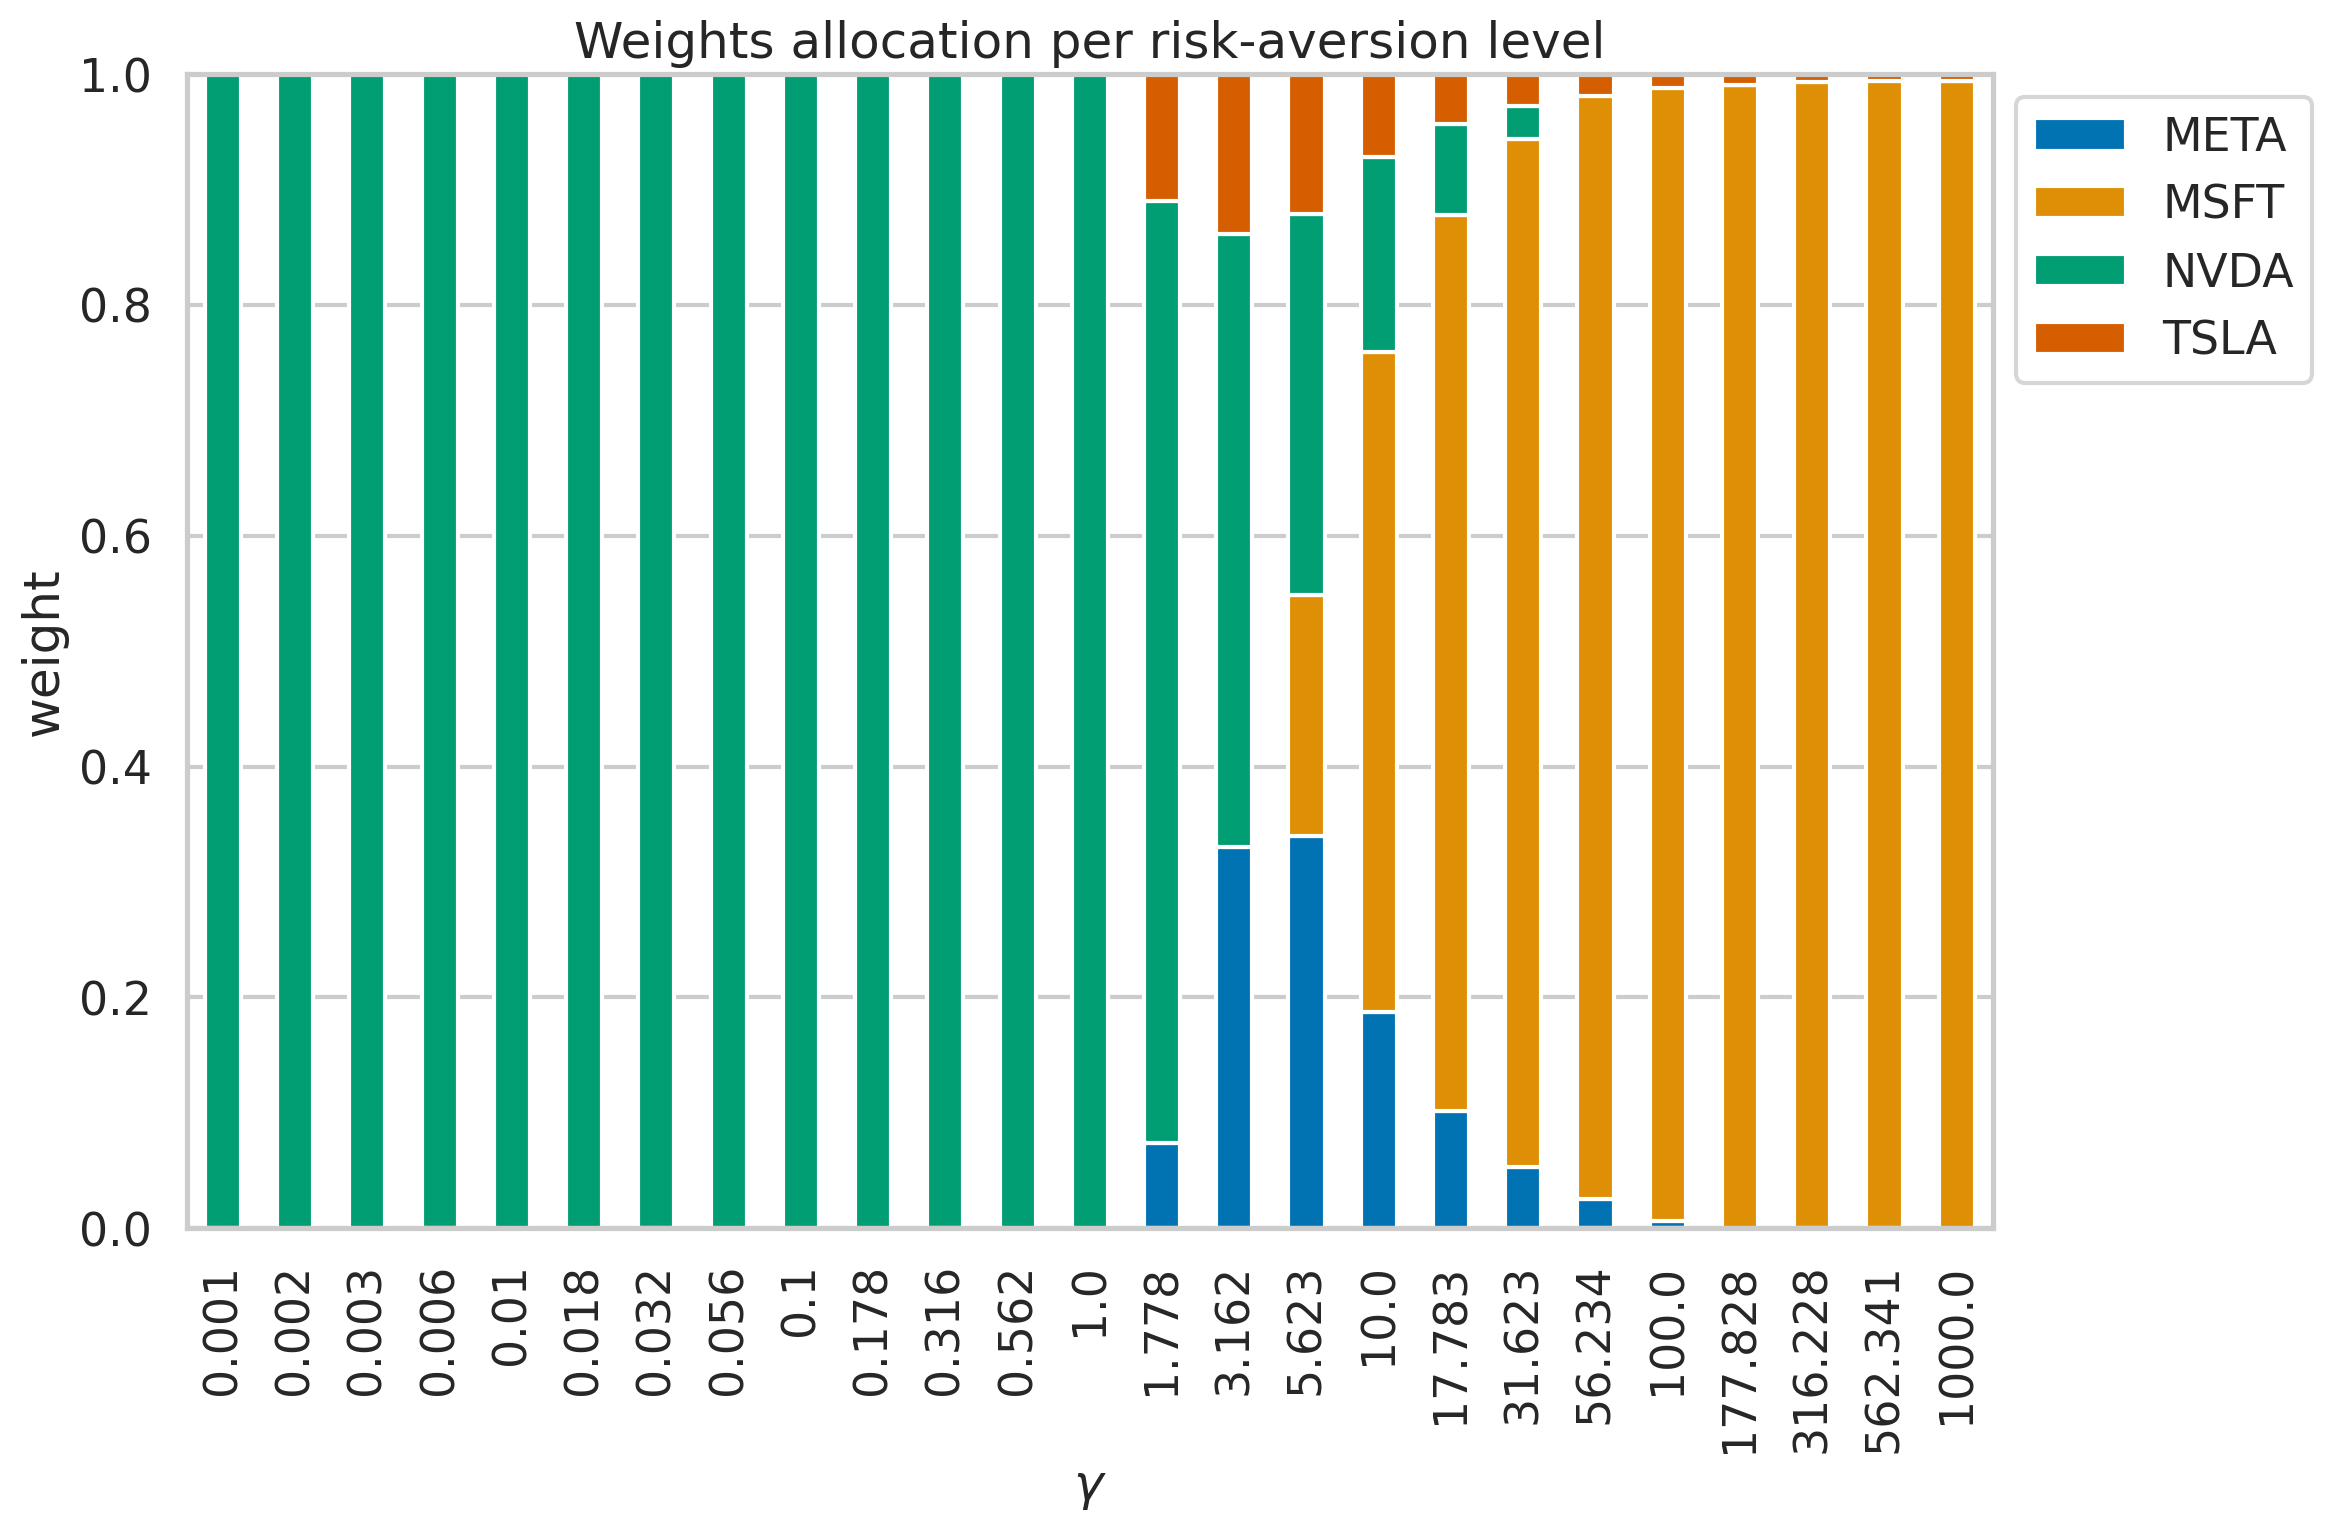

In [ ]:
weights_df = pd.DataFrame(weights_ef,
                          columns=RISKY_ASSETS,
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True)
ax.set(title='Weights allocation per risk-aversion level',
       xlabel=r'$\gamma$',
       ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

In the above plot, we see the asset allocation for the considered range of risk-aversion parameters.

6. Plot the Efficient Frontier, together with the individual assets:

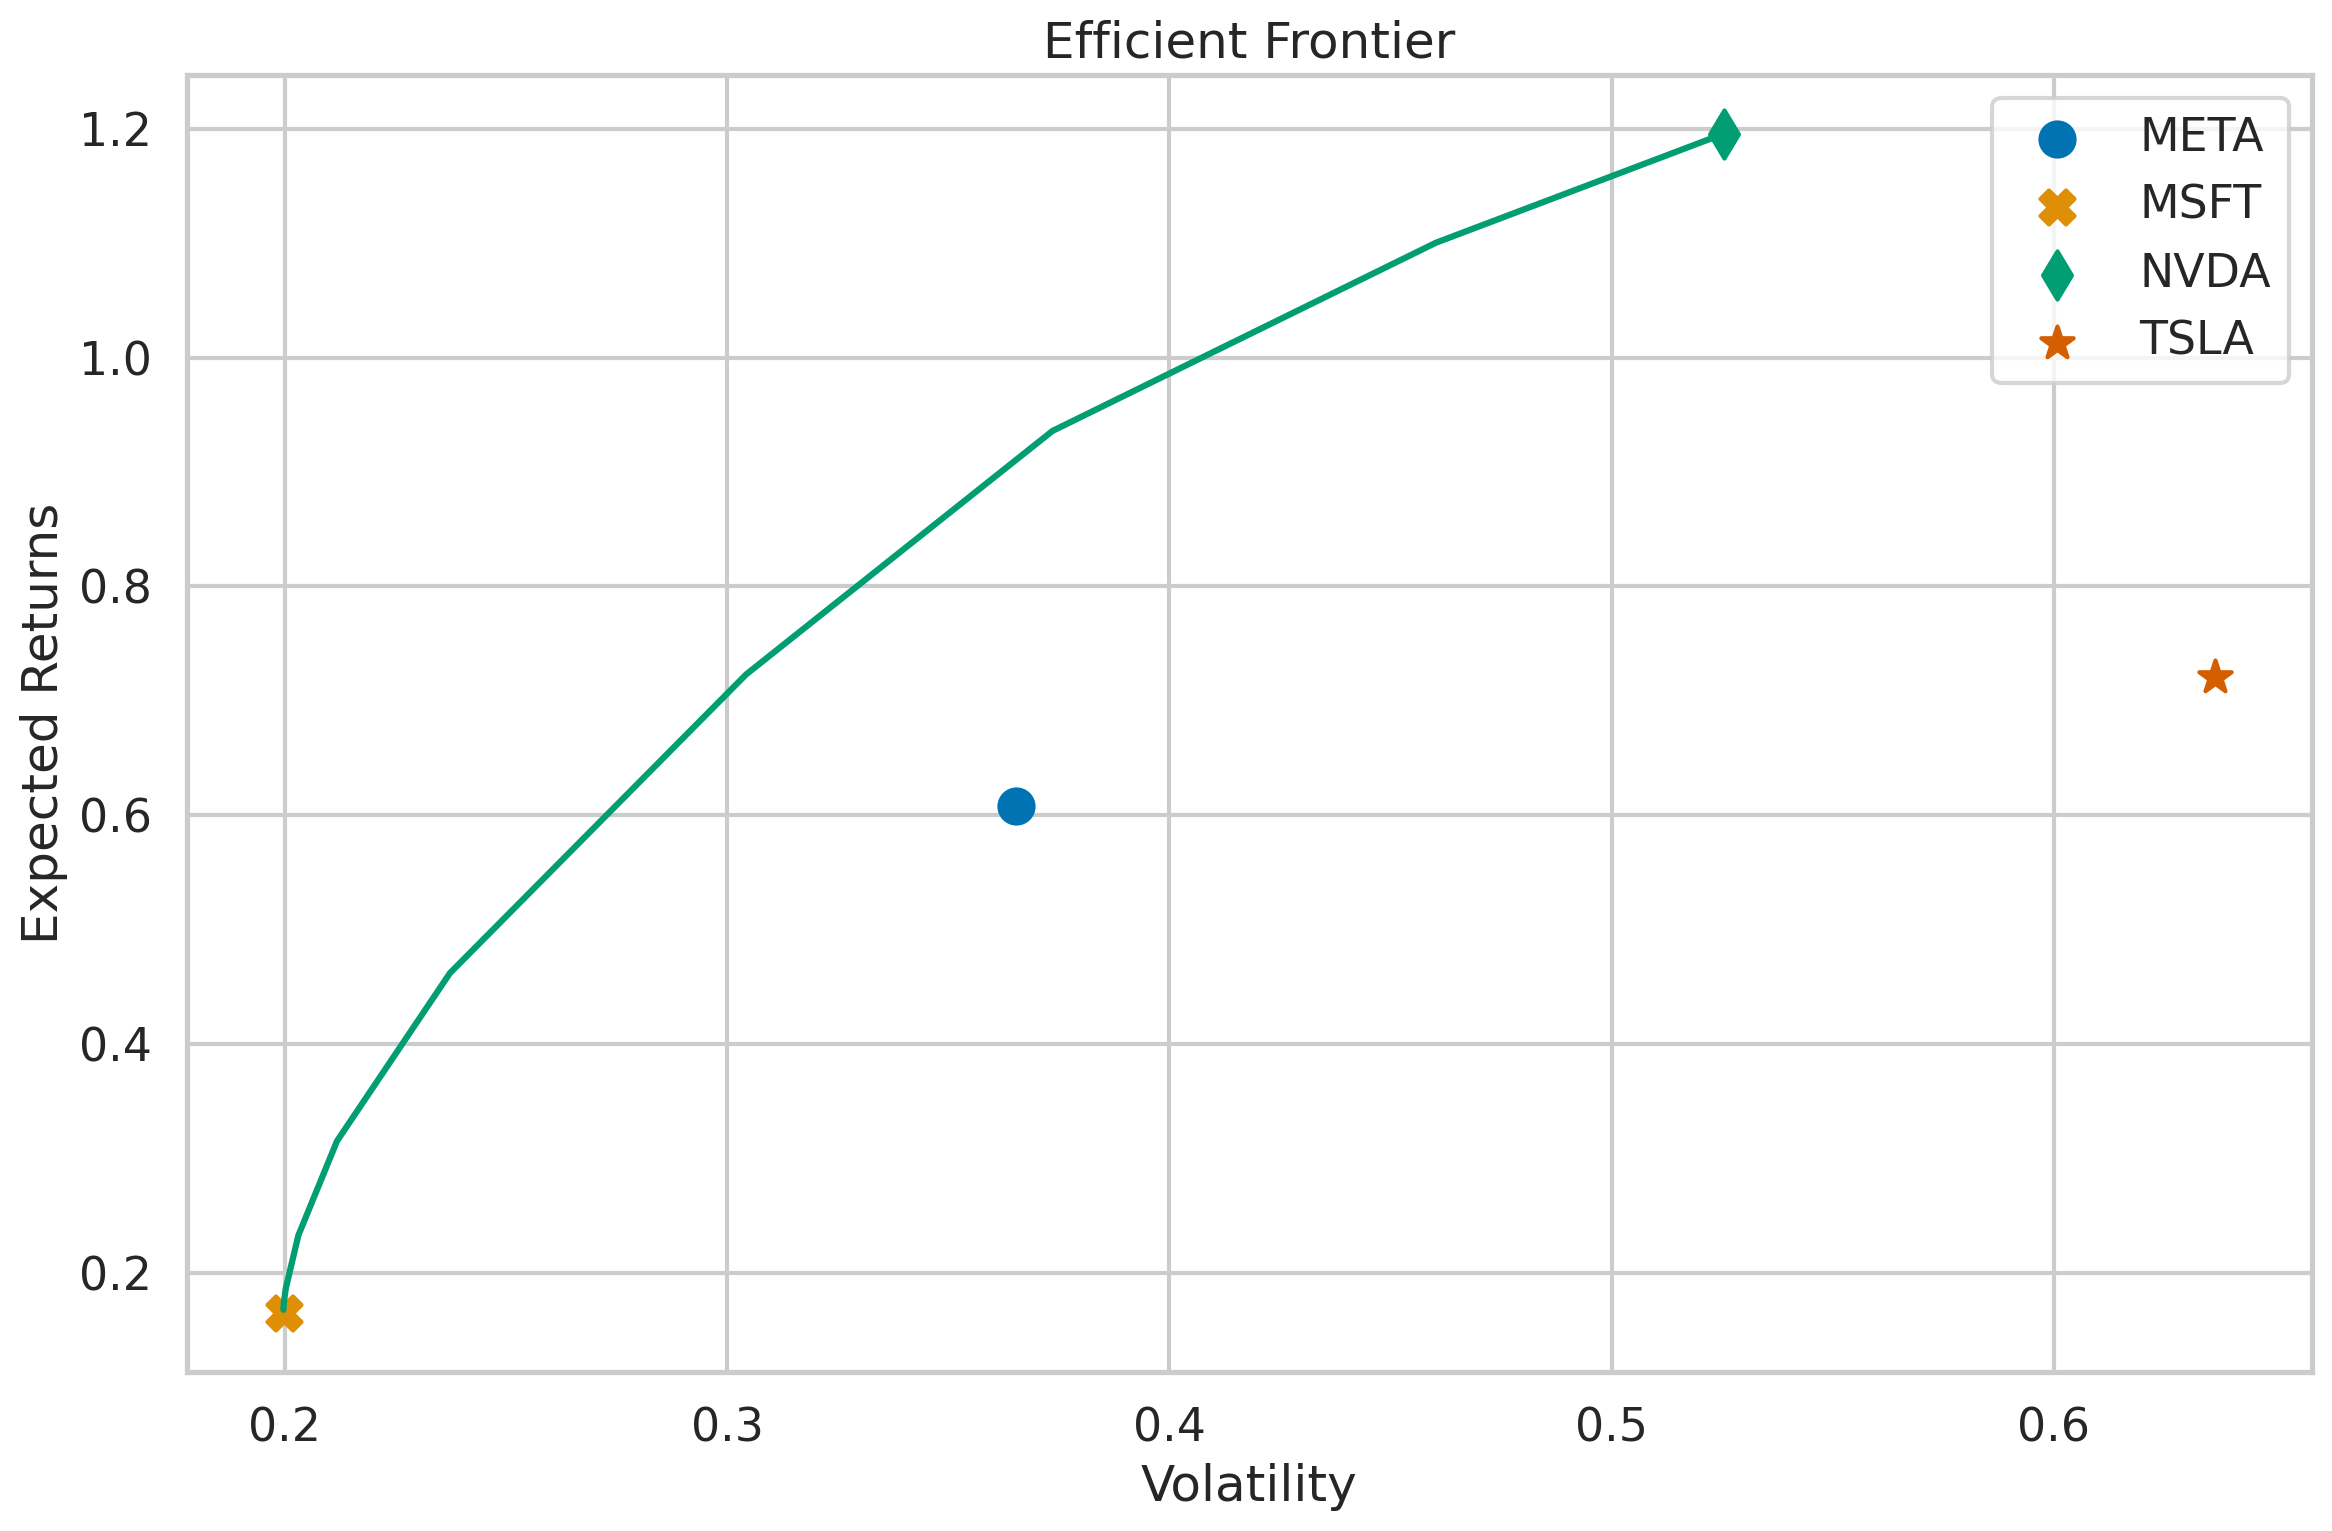

In [ ]:
#MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
# plot the efficient frontier
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
# plot the individual assets
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]),
                 y=avg_returns[asset_index],
                 marker=MARKS[asset_index],
                 label=RISKY_ASSETS[asset_index],
                 s=150)
ax.set(title='Efficient Frontier',
       xlabel='Volatility',
       ylabel='Expected Returns', )
ax.legend()

plt.tight_layout()
plt.show()

The above image shows a plot of the Efficient Frontier, generated by solving the convex optimization problem.


In the There's more... section, we also compare the frontier to the one obtained in the previous recipe, *Finding the Efficient Frontier using optimization with scipy*.

Summary:
1. As mentioned in the introduction, we continued the example from the previous two recipes. That is why we had to run Step 1 to 4 from the *Finding the Efficient Frontier using Monte Carlo simulations* recipe (not shown here for brevity) to have all the required data. As an extra step, we had to import the `cvxpy` convex optimization library. We additionally converted the historical average returns and the covariance matrix into `numpy` arrays.

2. In Step 3, we set up the optimization problem. We started by defining the target variables (`weights`), the risk-aversion parameter `gamma`, the portfolio returns and volatility (both using the previously defined `weights` variable), and lastly, the objective function—the risk-adjusted returns we want to maximize. Then, we created the `cp.Problem` object, and passed the objective function and a list of constraints as arguments.

3. In Step 4, we found the Efficient Frontier by solving the convex optimization problem for multiple values of the risk-aversion parameter. To define the values, we used the `np.logspace` function to get 25 values of $\omega$. For each value of the parameter, we found the optimal solution by running `problem.solve()`. We stored the values of interest in dedicated arrays or lists.

4. In Step 5, we plotted the asset allocation per various levels of risk aversion. In the plot, we could see that for very small values of $\omega$, the investor would allocate 100% of their resources to Twitter. As we increased the risk aversion, the allocation to Twitter grew smaller, and more weight was allocated to Microsoft and the other assets. At the other end of the considered values for the parameter, the investor would allocate 0% to Twitter.

5. In Step 6, we plotted the Efficient Frontier, together with the individual assets.

### There's more

We can also plot the two Efficient Frontiers for comparison—the one calculated by minimizing the volatility per expected level of return, and the other one using the convex optimization and maximizing the risk-adjusted return.

In [ ]:
rtns_range.max()

np.float64(0.32)

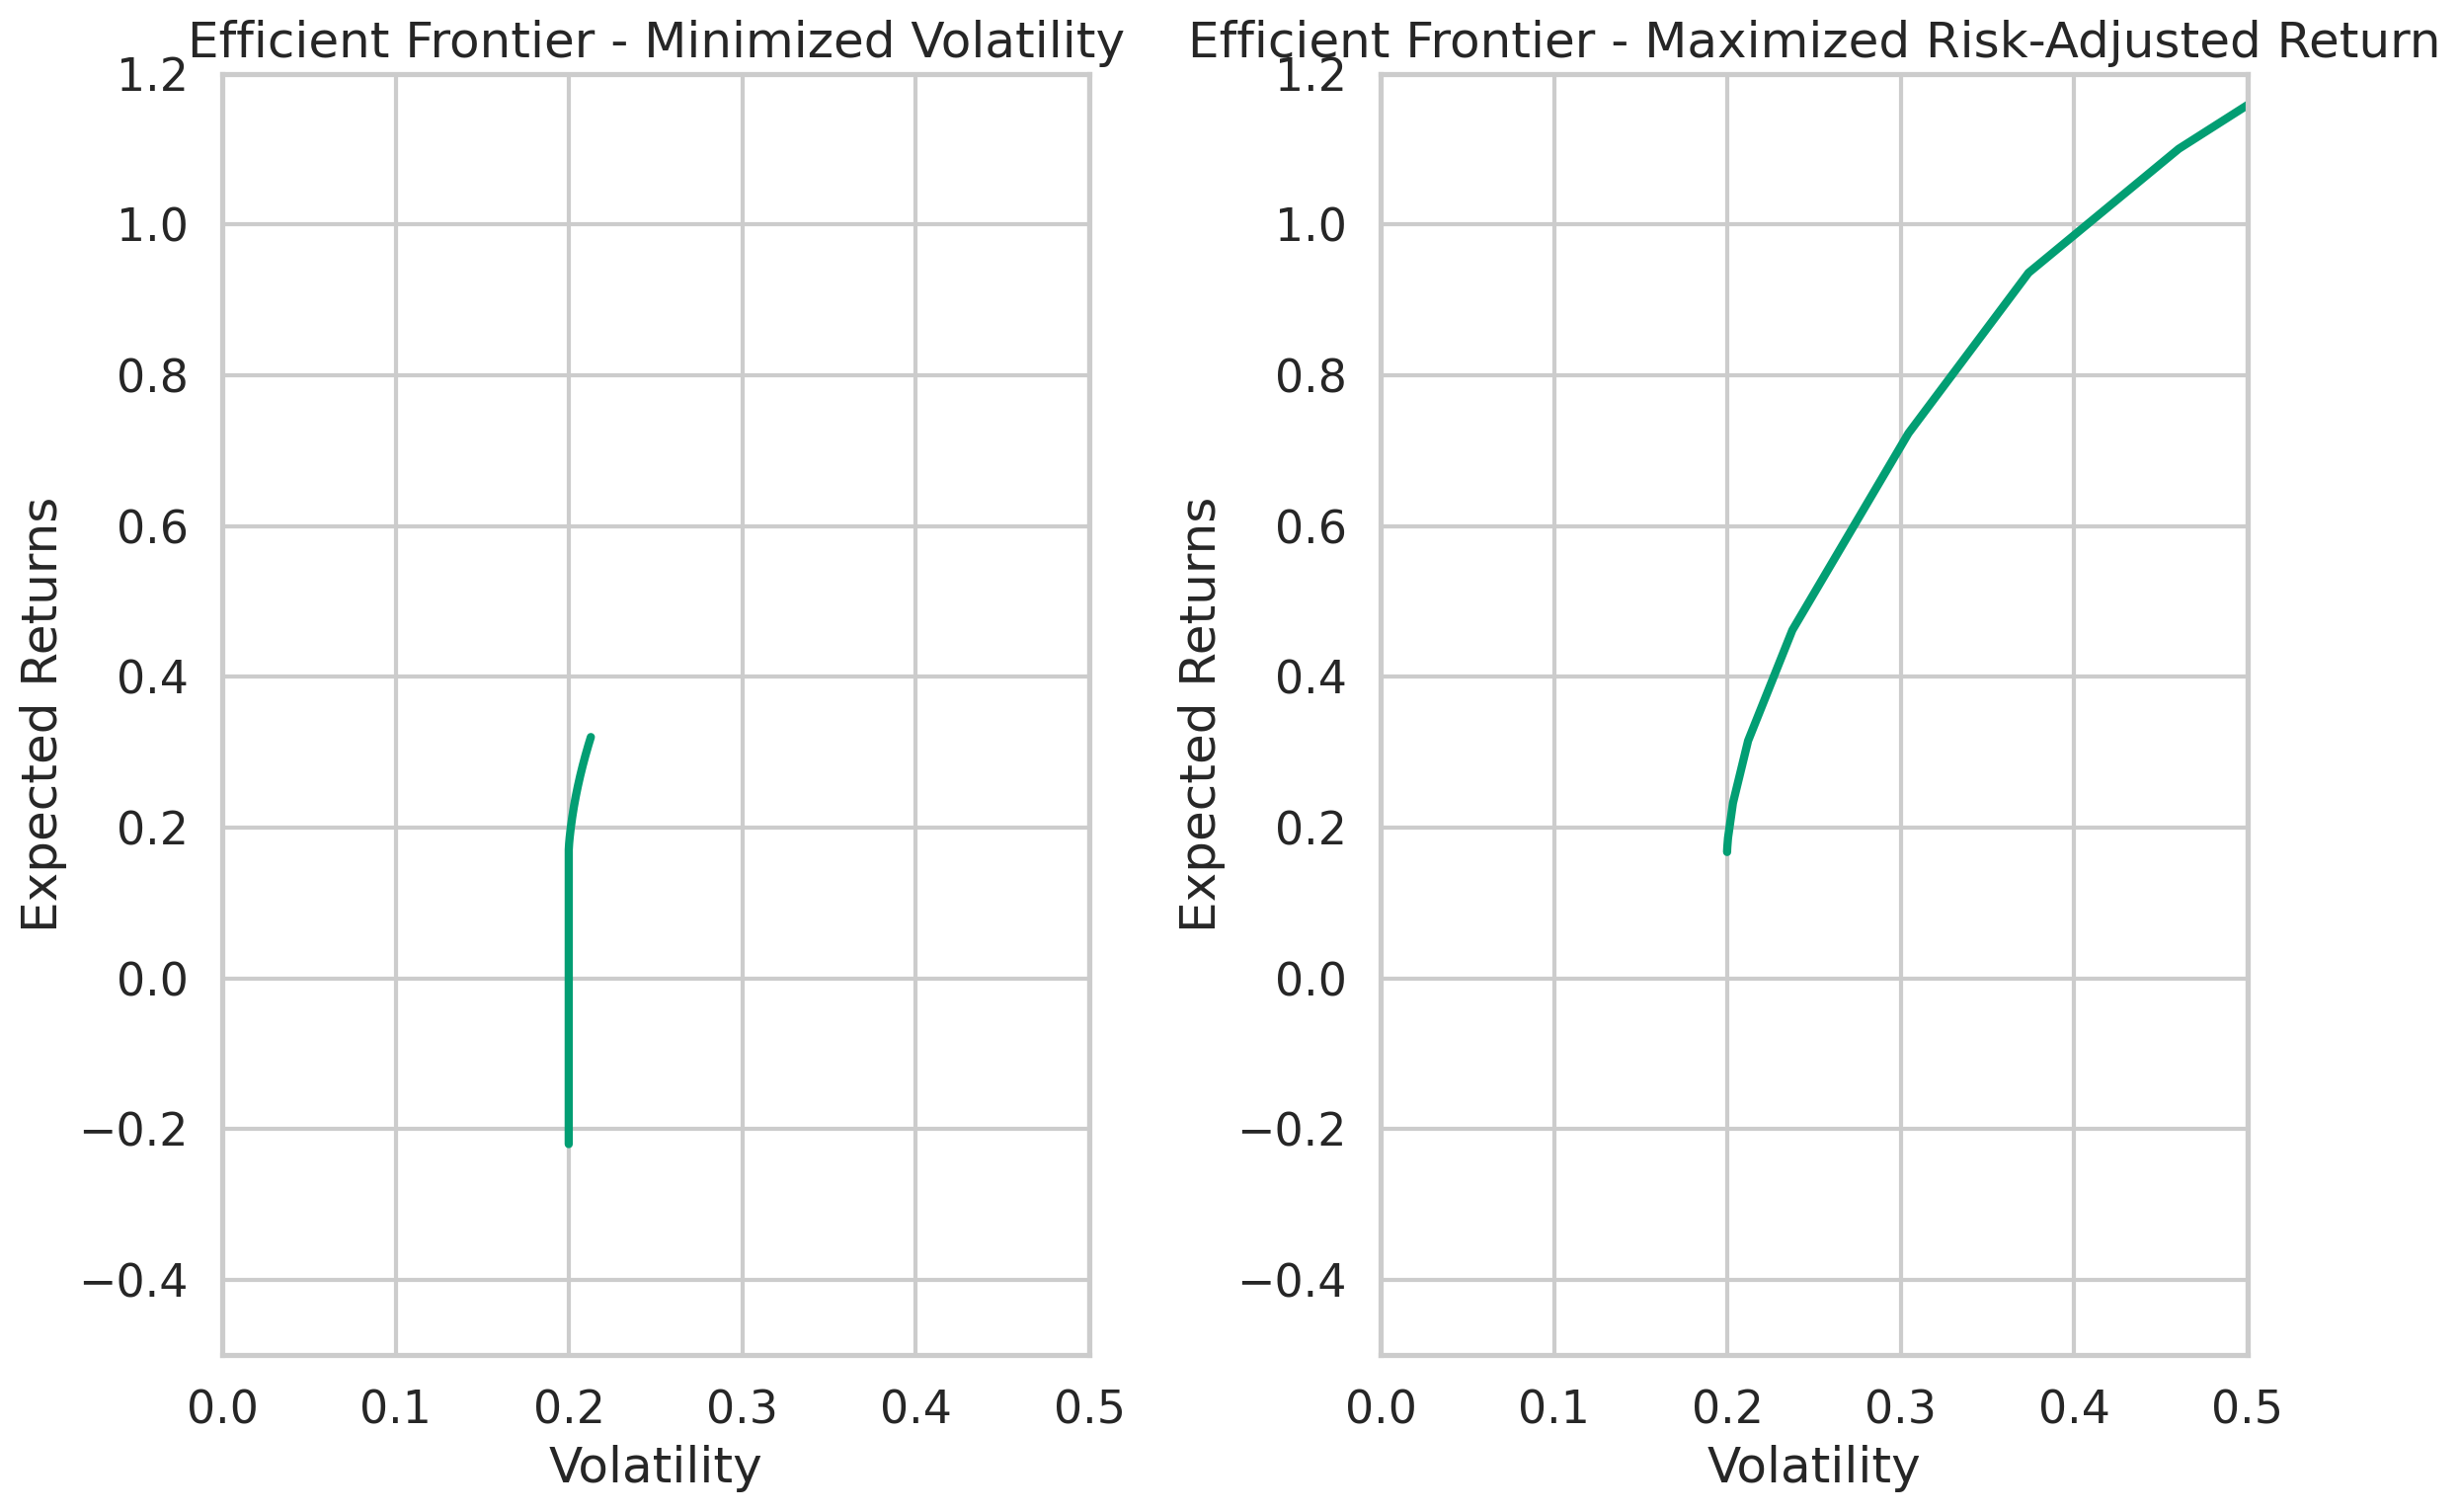

In [ ]:
x_lim = [0.0, 0.5]
y_lim = [-0.5, 1.2]

fig, ax = plt.subplots(1, 2)
ax[0].plot(vols_range, rtns_range, 'g-', linewidth=3)
ax[0].set(title='Efficient Frontier - Minimized Volatility',
          xlabel='Volatility',
          ylabel='Expected Returns',
          xlim=x_lim,
          ylim=y_lim)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-', linewidth=3)
ax[1].set(title='Efficient Frontier - Maximized Risk-Adjusted Return',
          xlabel='Volatility',
          ylabel='Expected Returns',
          xlim=x_lim,
          ylim=y_lim)

plt.tight_layout()
plt.show()

The only thing to note is that the one obtained using minimization is smoother, as we used more points to calculate the frontier.

Another interesting concept we can incorporate into the analysis is the maximum allowable leverage. We replace the non-negativity constraints on the weights with a max leverage constraint, using the norm of a vector.

In the following code, we only show what was added to the previous code block:

In [ ]:
max_leverage = cp.Parameter()
problem_with_leverage = cp.Problem(objective_function,
                                   [cp.sum(weights) == 1,
                                    cp.norm(weights, 1) <= max_leverage])

In the following code block, we modify the code, this time to include two loops—one over potential values of the risk-aversion parameter, and the other one indicating the maximum allowable leverage. Max leverage equal to 1 (meaning no leverage) results in a case similar to the previous optimization problem (only this time, there is no non-negativity constraint).

We also redefine the objects, storing the results to be either larger 2D matrices (`np.ndarrays`) or including a third dimension, in the case of weights.

In [ ]:
LEVERAGE_RANGE = [1, 2, 5]
len_leverage = len(LEVERAGE_RANGE)
N_POINTS = 25

portf_vol_l_ef = np.zeros((N_POINTS, len_leverage))
portf_rtn_l_ef = np.zeros(( N_POINTS, len_leverage))
weights_ef = np.zeros((len_leverage, N_POINTS, n_assets))

# over the potential values of the risk-aversion parameter
for lev_ind, leverage in enumerate(LEVERAGE_RANGE):
    # for each max leverage
    for gamma_ind in range(N_POINTS):
        max_leverage.value = leverage
        gamma.value = gamma_range[gamma_ind]
        problem_with_leverage.solve()
        portf_vol_l_ef[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l_ef[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value

* `enumerate(iterable, start=0)`
    * Return an enumerate object.
    * `iterable`: a sequence, an iterator, or objects that supports iteration
    * `start` (optional) - `enumerate()` starts counting from this number. If start is omitted, 0 is taken as start.
    * When you use `enumerate()`, the function gives you back two loop variables:
        * The count of the current iteration
        * The value of the item at the current iteration

In [ ]:
values=["a","b","c"]
for count, value in enumerate(values):
    print(count, value)

0 a
1 b
2 c


In the following code block, we plot the Efficient Frontiers for different maximum leverages. We can clearly see that higher leverage increases returns and, at the same time, allows for greater volatility.

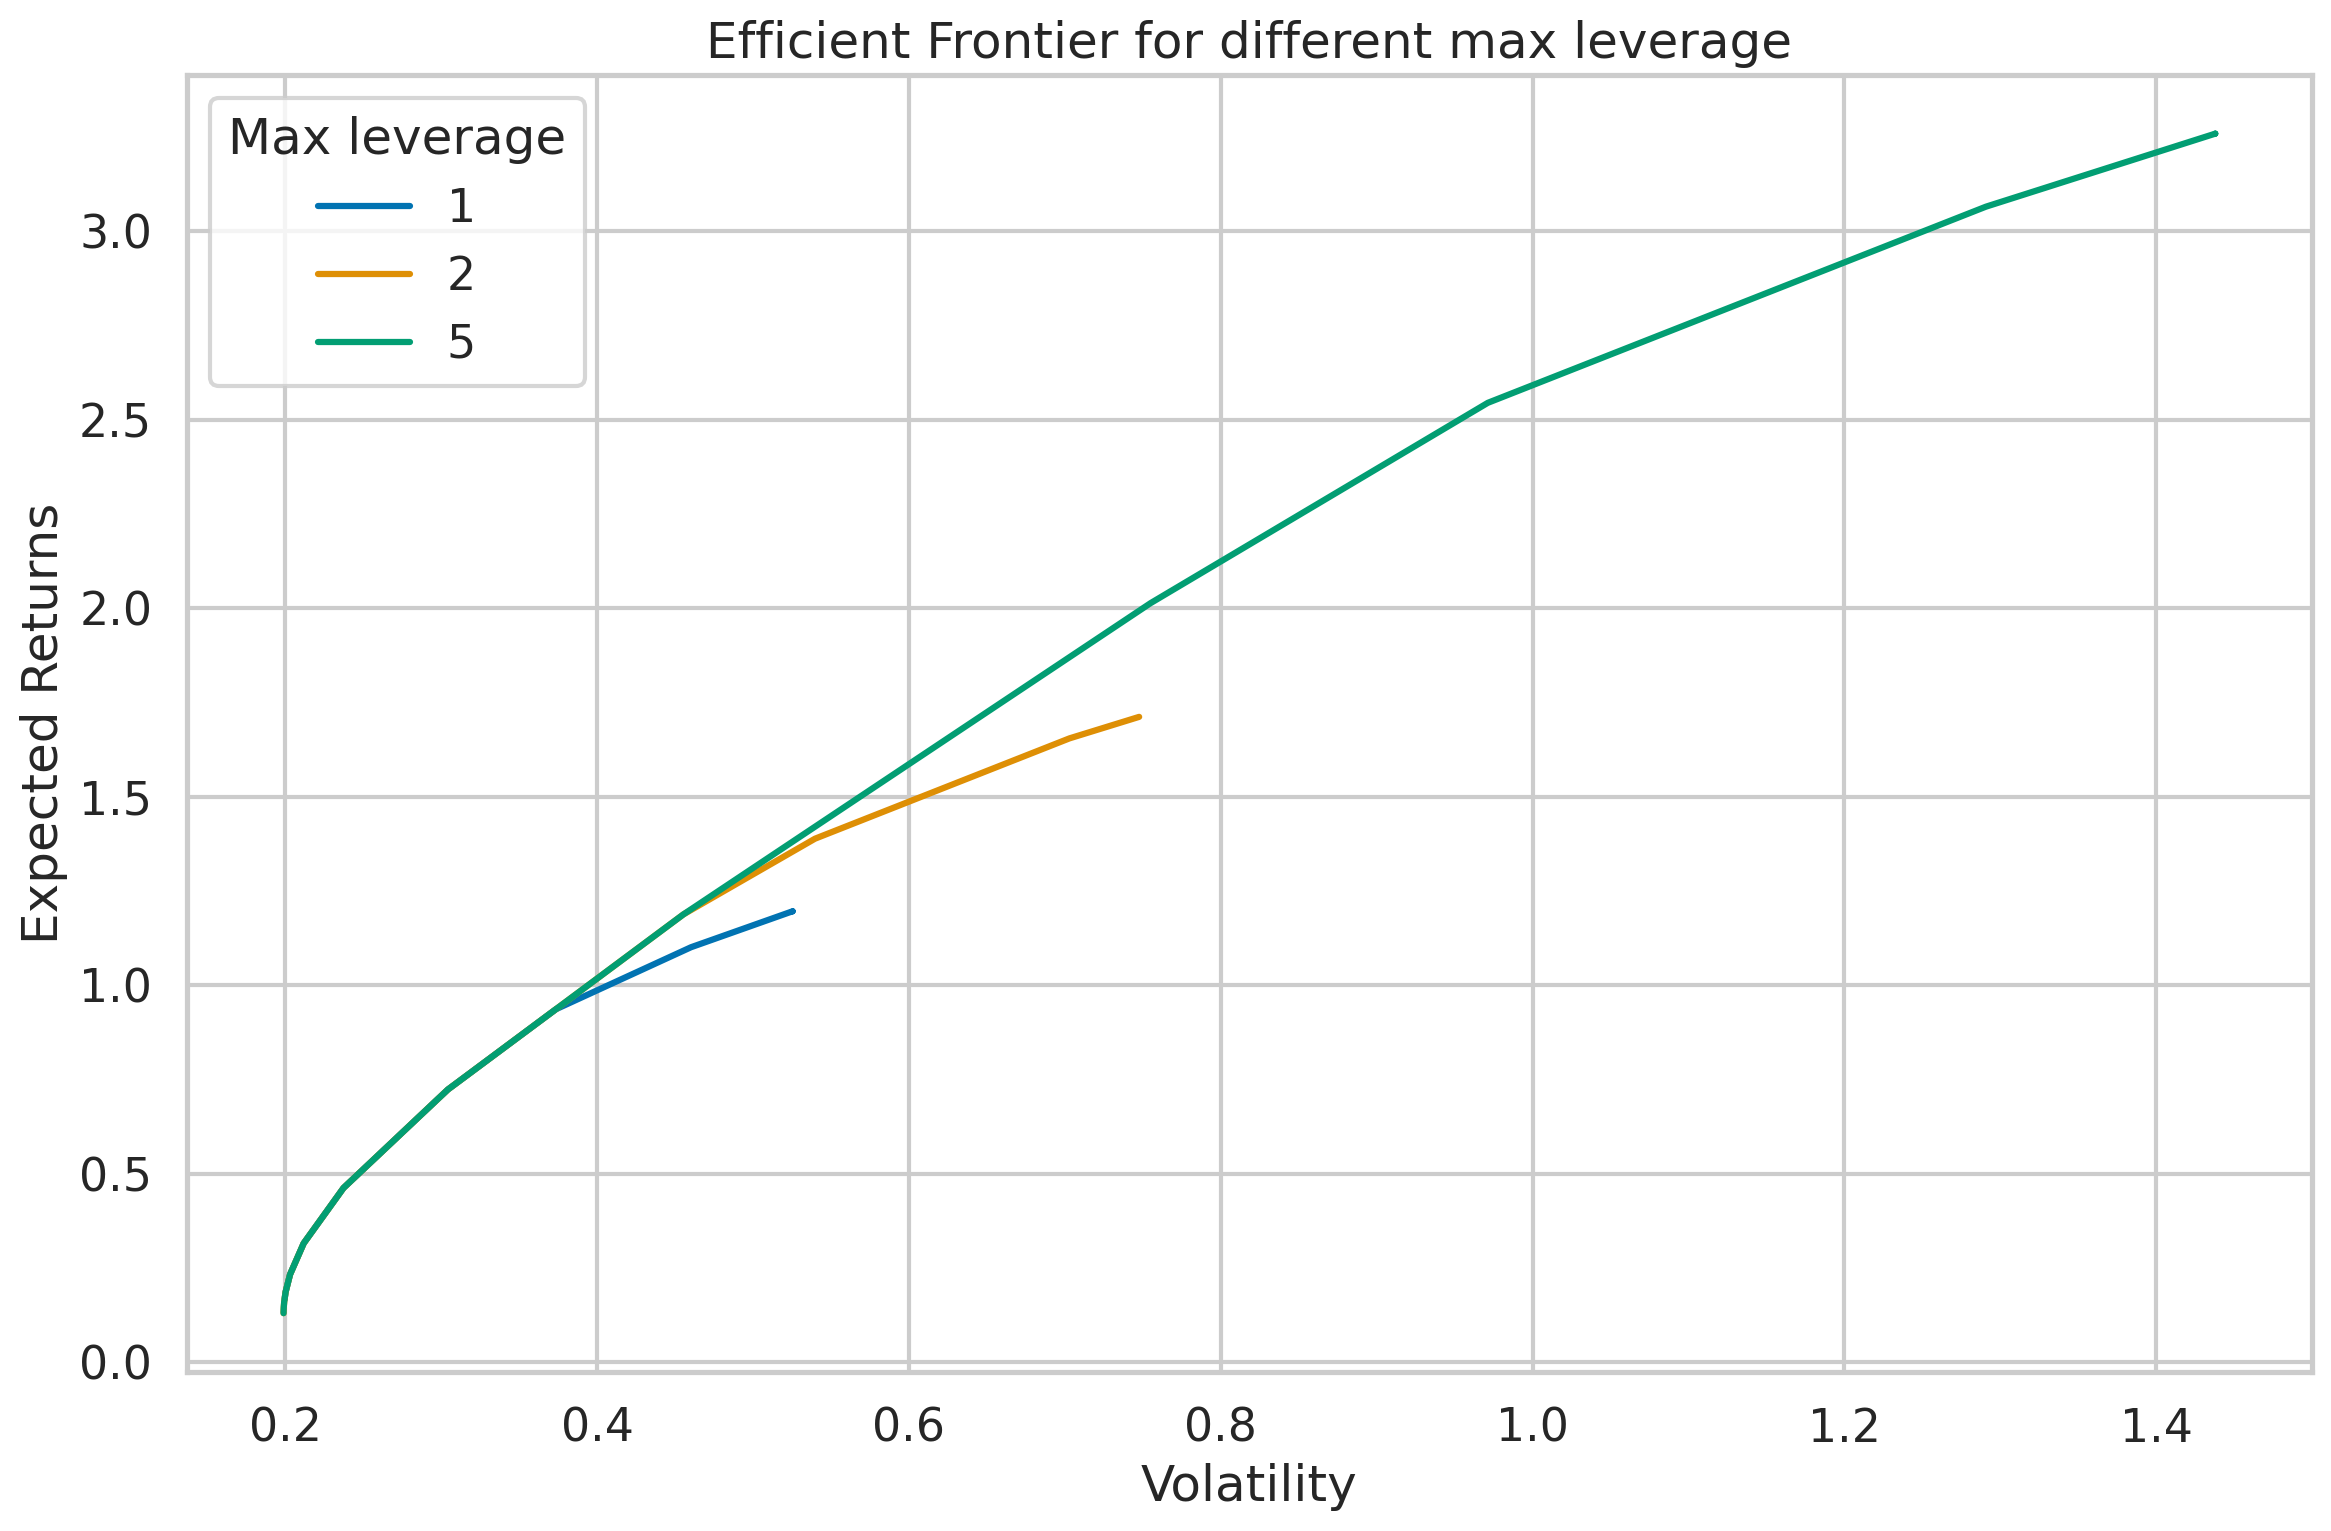

In [ ]:
fig, ax = plt.subplots()

for leverage_index, leverage in enumerate(LEVERAGE_RANGE):
    plt.plot(portf_vol_l_ef[:, leverage_index],
             portf_rtn_l_ef[:, leverage_index],
             label=f'{leverage}')

ax.set(title='Efficient Frontier for different max leverage',
       xlabel='Volatility',
       ylabel='Expected Returns')
ax.legend(title='Max leverage')

plt.tight_layout()
plt.show()

Lastly, we also recreate the plot showing weight allocation per varying risk-aversion levels. With a maximum leverage of 1, there is no short-selling.

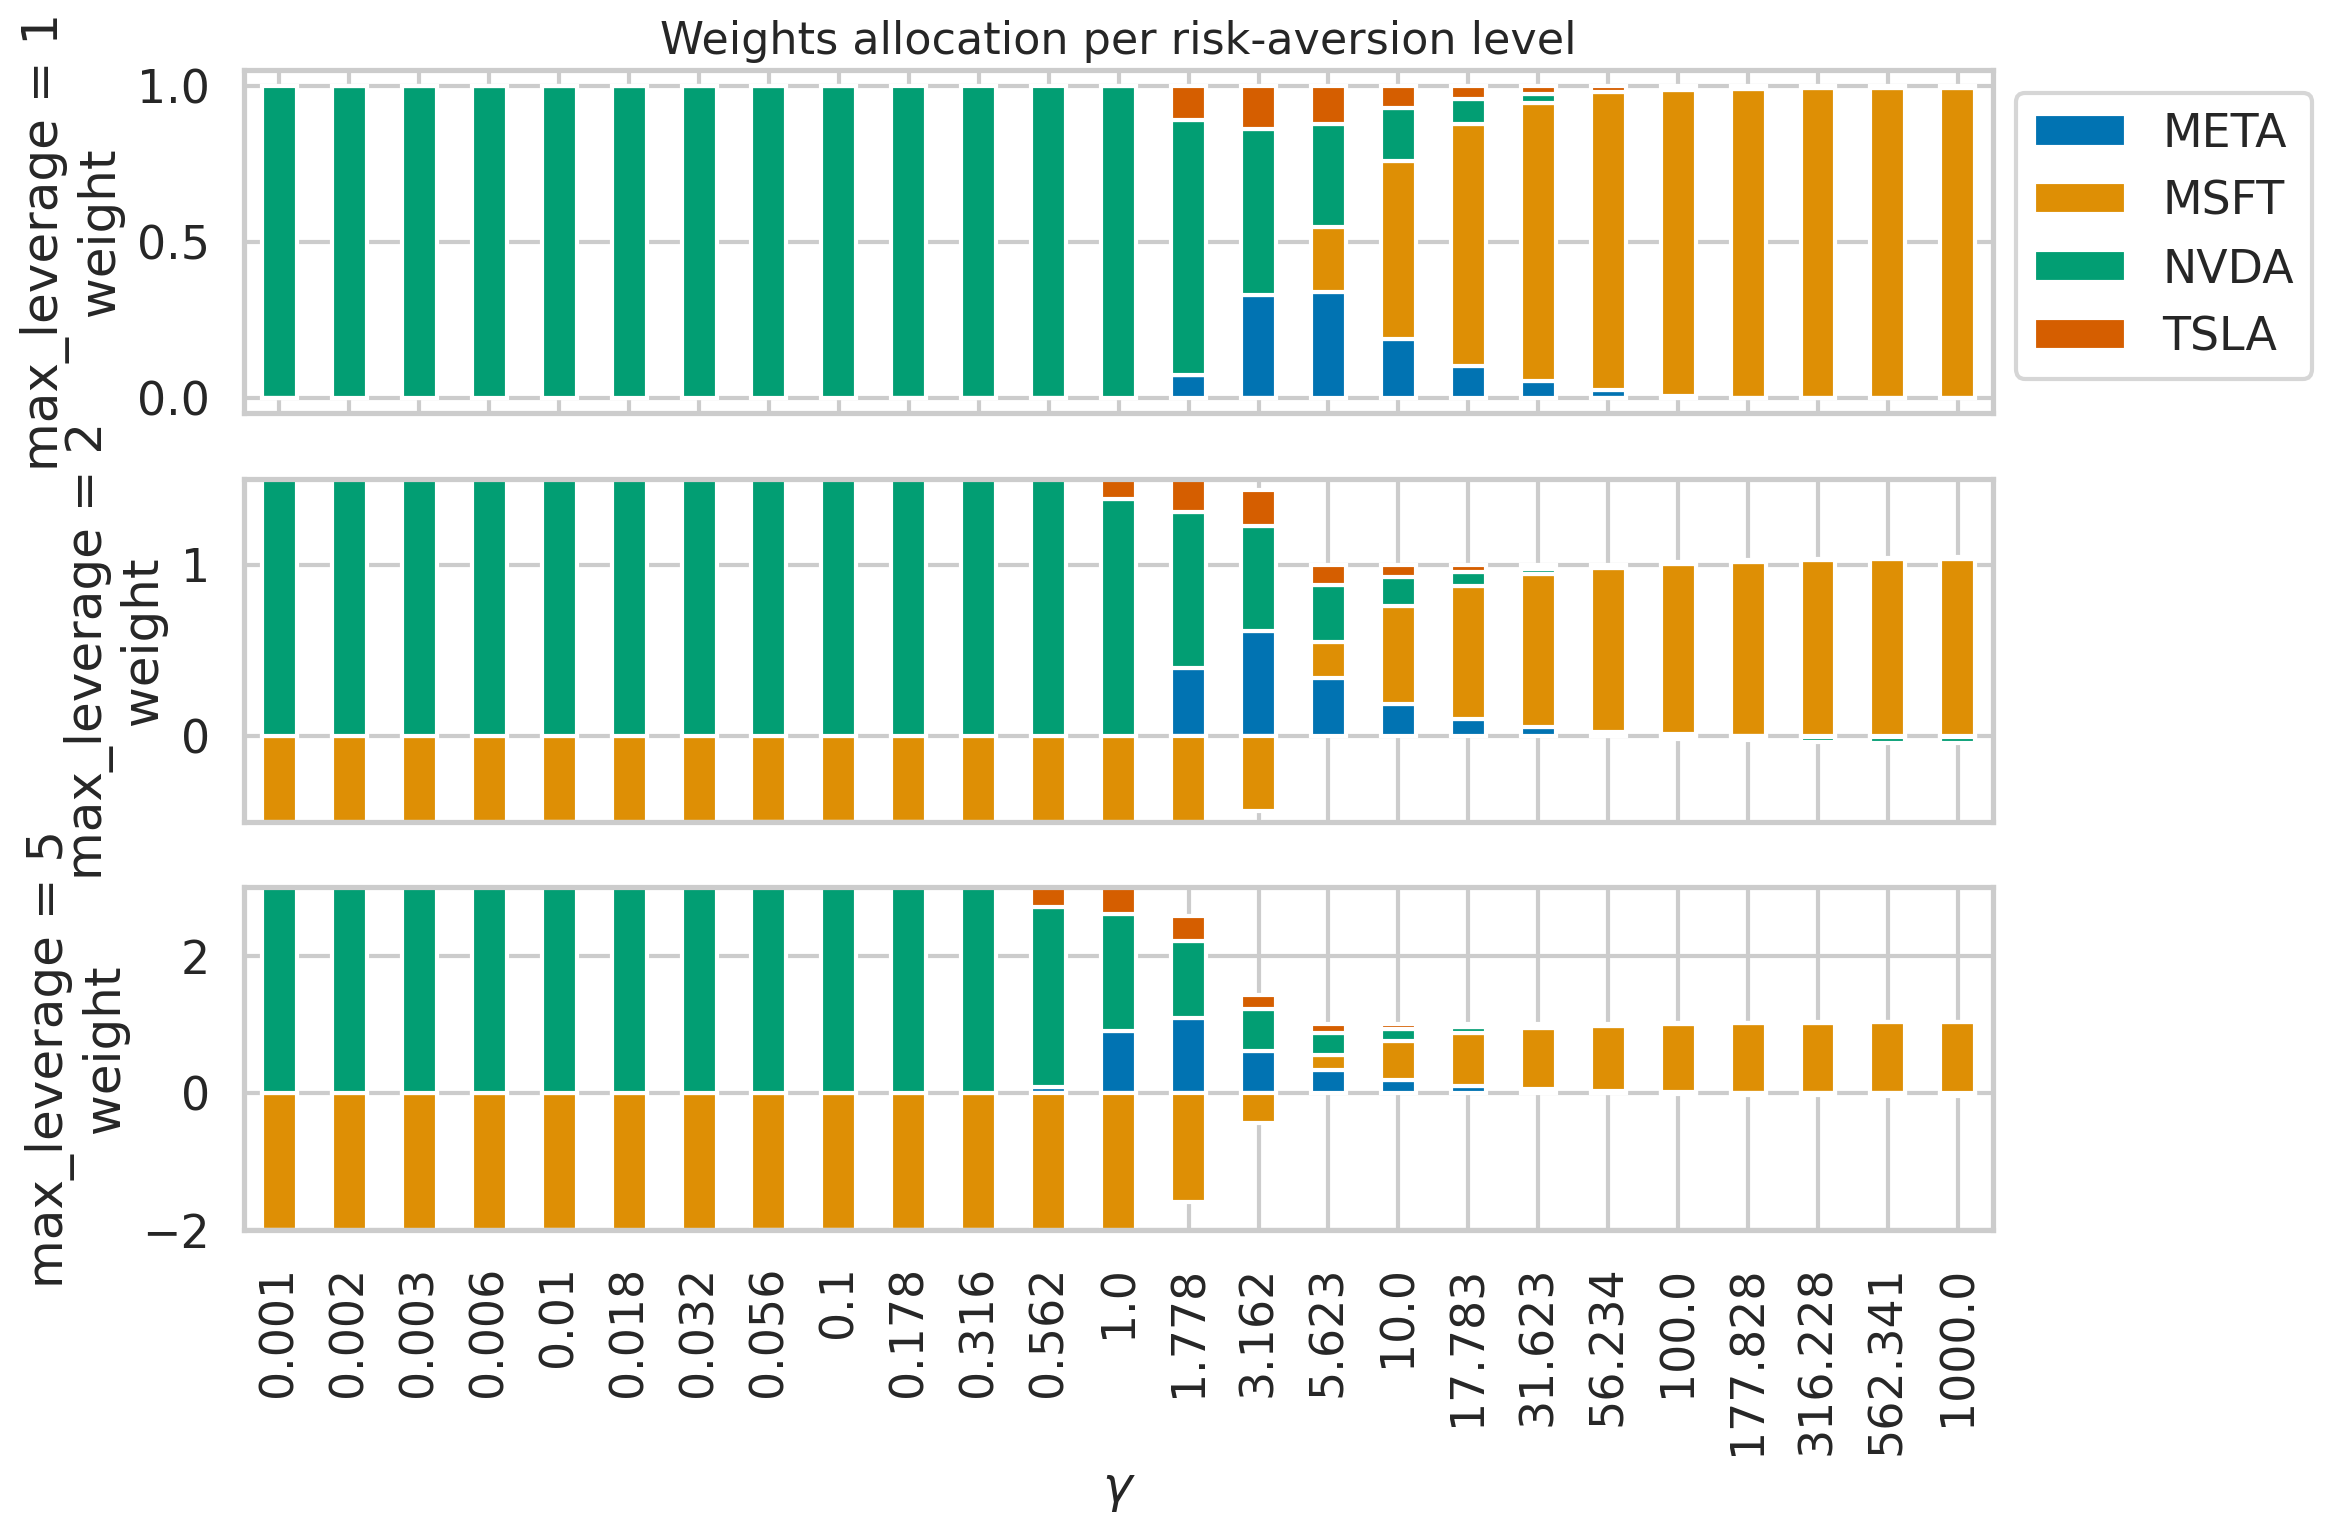

In [ ]:
fig, ax = plt.subplots(len_leverage, 1, sharex=True)

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame(weights_ef[ax_index],
                              columns=RISKY_ASSETS,
                              index=np.round(gamma_range, 3))
    weights_df.plot(kind='bar',
                    stacked=True, # stacked plot
                    ax=ax[ax_index],
                    legend=None)
    ax[ax_index].set(ylabel=(f'max_leverage = {LEVERAGE_RANGE[ax_index]}'
                             '\n weight'))


ax[len_leverage - 1].set(xlabel=r'$\gamma$')
ax[0].legend(bbox_to_anchor=(1,1)) #`bbox_to_anchor`: control for manual legend placement, specify the coordinate system of that location
ax[0].set_title('Weights allocation per risk-aversion level',
                fontsize=16)

plt.tight_layout()
plt.show()

We can spot a pattern where, with an increase in risk aversion, investors stop using leverage altogether, and converge to a similar allocation for all levels of maximum permitted leverage.